# Health Data Mining and Analytics - Complete Data Science Project

## MSc Public Health Data Science - SDS6108

---

### Project Overview

This comprehensive data science project demonstrates the complete workflow for analyzing behavioral risk factor data from the Behavioral Risk Factor Surveillance System (BRFSS). The project covers all phases from data collection and preprocessing through to predictive modeling and interpretation of results, providing a complete template for health data mining and analytics.

---

### Learning Objectives

Upon completing this notebook, you will be able to:

1. **Understand the data science pipeline**: Grasp the end-to-end workflow from raw data to actionable insights
2. **Apply data preprocessing techniques**: Handle missing values, outliers, and data quality issues
3. **Conduct exploratory data analysis**: Use statistical and visualization techniques to understand health data
4. **Perform feature engineering**: Create meaningful features from raw health indicators
5. **Build predictive models**: Apply machine learning algorithms to health outcomes
6. **Evaluate model performance**: Use appropriate metrics for healthcare prediction tasks
7. **Interpret results**: Translate statistical findings into public health insights

---

### Project Structure

| Phase | Description | Key Activities |
|-------|-------------|----------------|
| Phase 1 | Project Setup | Library imports, configuration, data loading |
| Phase 2 | Data Exploration | Initial assessment, descriptive statistics, data types |
| Phase 3 | Data Cleaning | Missing value treatment, outlier handling, validation |
| Phase 4 | Exploratory Analysis | Univariate, bivariate, and multivariate analysis |
| Phase 5 | Feature Engineering | Variable transformation, creation of derived features |
| Phase 6 | Model Development | Algorithm selection, training, hyperparameter tuning |
| Phase 7 | Model Evaluation | Performance metrics, validation, comparison |
| Phase 8 | Results & Conclusions | Interpretation, limitations, recommendations |

---

### Key Features

- **Persistent Storage**: All outputs saved to file paths using STAGE_DIRS
- **Interactive Prediction Tool**: User-friendly interface for healthcare predictions
- **Comprehensive Visualizations**: All figures displayed and saved with location echo
- **Multiple Model Comparison**: Traditional ML and model evaluation

---

## Configuration: Persistent Path Management System

This cell sets up all directory paths and helper functions for persistent storage. All outputs (figures, models, data) will be saved to persistent file paths.


In [1]:
# ============================================================================
# EMBEDDED CONFIGURATION AND UTILITIES
# This cell contains ALL project configuration and utility functions.
# NO external file imports required - the notebook is now self-contained.
# ============================================================================

import os
import sys
import time
import json
import logging
from pathlib import Path
from typing import Union, Any, Optional, Dict, List, Tuple
from datetime import datetime
from contextlib import contextmanager

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from scipy import stats
from scipy.stats import ks_2samp, chi2_contingency, ttest_ind, mannwhitneyu
from sklearn.calibration import calibration_curve
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve,
    brier_score_loss
)

# ============================================================================
# PROJECT ROOT CONFIGURATION
# ============================================================================

def find_project_root():
    """Automatically detect the project root directory."""
    current_path = Path.cwd().resolve()
    
    for parent in [current_path] + list(current_path.parents):
        has_data_dir = (parent / 'data').exists()
        has_notebooks_dir = (parent / 'notebooks').exists()
        has_git = (parent / '.git').exists()
        has_outputs_dir = (parent / 'outputs').exists() or (parent / 'output_v2').exists()
        
        if has_data_dir and (has_notebooks_dir or has_git or has_outputs_dir):
            return parent
    
    config_file = Path(__file__).resolve() if '__file__' in dir() else Path.cwd()
    return config_file.parent

PROJECT_ROOT = find_project_root()

print("=" * 70)
print("PROJECT PATH CONFIGURATION")
print("=" * 70)
print(f"Project Root: {PROJECT_ROOT}")
print(f"Detected at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("-" * 70)

# ============================================================================
# MAIN DIRECTORY PATHS
# ============================================================================

DATA_DIR = PROJECT_ROOT / 'data'
OUTPUT_DIR = PROJECT_ROOT / 'output_v2'
print(f"Data Directory: {DATA_DIR}")
print(f"Output Directory: {OUTPUT_DIR}")

# ============================================================================
# SUB-DIRECTORY PATHS
# ============================================================================

MODELS_DIR = OUTPUT_DIR / 'models'
FIGURES_DIR = OUTPUT_DIR / 'figures'
DATA_EXPORTS_DIR = OUTPUT_DIR / 'data_exports'
RESULTS_DIR = OUTPUT_DIR / 'results'
LOGS_DIR = OUTPUT_DIR / 'logs'
DEPLOYMENT_DIR = OUTPUT_DIR / 'deployment'
CALIBRATION_DIR = OUTPUT_DIR / 'calibration'
DRIFT_DIR = OUTPUT_DIR / 'drift_detection'
INTERPRETABILITY_DIR = OUTPUT_DIR / 'interpretability'

print("-" * 70)
print("Sub-directories:")
print(f"  Models: {MODELS_DIR}")
print(f"  Figures: {FIGURES_DIR}")
print(f"  Data Exports: {DATA_EXPORTS_DIR}")
print(f"  Results: {RESULTS_DIR}")
print(f"  Logs: {LOGS_DIR}")
print(f"  Deployment: {DEPLOYMENT_DIR}")
print(f"  Calibration: {CALIBRATION_DIR}")
print(f"  Drift Detection: {DRIFT_DIR}")
print(f"  Interpretability: {INTERPRETABILITY_DIR}")

# ============================================================================
# STAGE-SPECIFIC FIGURE DIRECTORIES
# ============================================================================

STAGES = [
    'data_exploration',
    'feature_engineering',
    'model_training',
    'model_evaluation',
    'clinical_validation',
    'interpretability',
    'error_analysis',
    'fairness_analysis'
]

STAGE_DIRS = {
    'data_exploration': FIGURES_DIR / 'data_exploration',
    'feature_engineering': FIGURES_DIR / 'feature_engineering',
    'model_training': FIGURES_DIR / 'model_training',
    'model_evaluation': FIGURES_DIR / 'model_evaluation',
    'clinical_validation': FIGURES_DIR / 'clinical_validation',
    'interpretability': FIGURES_DIR / 'interpretability',
    'error_analysis': FIGURES_DIR / 'error_analysis',
    'fairness_analysis': FIGURES_DIR / 'fairness_analysis'
}

print("-" * 70)
print("Stage-specific figure directories:")
for stage, path in STAGE_DIRS.items():
    print(f"  {stage}: {path}")

# ============================================================================
# DATA FILE PATHS
# ============================================================================

DATA_PATH_CSV = DATA_DIR / 'behavioral risk factor-selected.csv'
DATA_PATH_XLSX = DATA_DIR / 'behavioral risk factor analysis.xlsx'
DATA_PATH = DATA_DIR / 'diabetes.csv'

print("-" * 70)
print("Data file paths:")
print(f"  CSV: {DATA_PATH_CSV}")
print(f"  XLSX: {DATA_PATH_XLSX}")
print(f"  Default: {DATA_PATH}")

# ============================================================================
# FAIRNESS AND SUBGROUP CONFIGURATION
# ============================================================================

FAIRNESS_SUBGROUPS = {
    'Age': {
        'young': lambda df: df['Age'] < 45,
        'middle_aged': lambda df: (df['Age'] >= 45) & (df['Age'] < 65),
        'senior': lambda df: df['Age'] >= 65
    },
    'Sex': {
        'male': lambda df: df['Sex'] == 1,
        'female': lambda df: df['Sex'] == 0
    },
    'Education': {
        'low_education': lambda df: df['Education'] <= 2,
        'high_education': lambda df: df['Education'] > 2
    },
    'Income': {
        'low_income': lambda df: df['Income'] < 50000,
        'high_income': lambda df: df['Income'] >= 50000
    }
}

FAIRNESS_THRESHOLDS = {
    'demographic_parity_diff': 0.25,
    'equal_opportunity_diff': 0.25,
    'predictive_parity_diff': 0.25,
    'calibration_diff': 0.05
}

# ============================================================================
# CLINICAL VALIDATION PARAMETERS
# ============================================================================

CLINICAL_VALIDATION = {
    'calibration_bins': 10,
    'decision_threshold_range': list(range(0, 101, 5)),
    'external_validation_sample_size': 0.3,
    'minimum_sample_size_per_bin': 30
}

# ============================================================================
# DRIFT DETECTION PARAMETERS
# ============================================================================

DRIFT_CONFIG = {
    'method': 'psi',
    'psi_threshold': 0.2,
    'ks_test_alpha': 0.05,
    'reference_data_size': 10000,
    'monitoring_features': ['Age', 'BMI', 'BloodPressure', 'Cholesterol', 'Income']
}

# ============================================================================
# SHAP AND MODEL INTERPRETABILITY SETTINGS
# ============================================================================

SHAP_CONFIG = {
    'max_display': 20,
    'plot_type': 'summary',
    'sample_size': 500,
    'feature_perturbation': 'tree_path_dependent',
    'background_samples': 100
}

# ============================================================================
# REPRODUCIBILITY SETTINGS
# ============================================================================

REPRODUCIBILITY = {
    'random_seed': 42,
    'numpy_random_seed': 42,
    'python_hash_seed': 42,
    'tensorflow_determinism': False,
    'torch_manual_seed': 42
}

# ============================================================================
# VISUALIZATION STYLE SETTINGS
# ============================================================================

VISUALIZATION_STYLE = {
    'figsize_large': (14, 10),
    'figsize_medium': (10, 7),
    'figsize_small': (6, 4),
    'dpi': 150,
    'color_palette': 'viridis',
    'style_sheet': 'seaborn-v0_8-whitegrid',
    'font_size_title': 14,
    'font_size_axis': 12,
    'font_size_label': 11
}

# ============================================================================
# DIRECTORY CREATION
# ============================================================================

def create_directory_structure():
    """Create all project directories if they don't exist."""
    print("-" * 70)
    print("Creating directory structure...")
    
    main_dirs = [
        OUTPUT_DIR, MODELS_DIR, FIGURES_DIR, DATA_EXPORTS_DIR,
        RESULTS_DIR, LOGS_DIR, DEPLOYMENT_DIR, CALIBRATION_DIR,
        DRIFT_DIR, INTERPRETABILITY_DIR
    ]
    
    for directory in main_dirs:
        if not directory.exists():
            directory.mkdir(parents=True, exist_ok=True)
            print(f"  Created: {directory}")
        else:
            print(f"  Exists: {directory}")
    
    print("\nCreating stage-specific figure directories:")
    for stage, path in STAGE_DIRS.items():
        if not path.exists():
            path.mkdir(parents=True, exist_ok=True)
            print(f"  Created: {path}")
        else:
            print(f"  Exists: {path}")
    
    print("\nDirectory structure creation complete!")
    return True

create_directory_structure()

# ============================================================================
# PATH HELPER FUNCTIONS
# ============================================================================

def get_output_path(subfolder: str, filename: str) -> Path:
    """Get a full path for saving files in output subdirectories."""
    folder_map = {
        'models': MODELS_DIR, 'data_exports': DATA_EXPORTS_DIR,
        'results': RESULTS_DIR, 'logs': LOGS_DIR, 'figures': FIGURES_DIR,
        'deployment': DEPLOYMENT_DIR, 'calibration': CALIBRATION_DIR,
        'drift': DRIFT_DIR, 'interpretability': INTERPRETABILITY_DIR
    }
    
    if subfolder not in folder_map:
        raise ValueError(f"Unknown subfolder '{subfolder}'")
    
    return folder_map[subfolder] / filename

def get_figure_path(stage: str, filename: str) -> Path:
    """Get a full path for saving figures in stage-specific directories."""
    if stage not in STAGES:
        raise ValueError(f"Unknown stage '{stage}'")
    return STAGE_DIRS[stage] / filename

# ============================================================================
# LOGGING SETUP
# ============================================================================

def setup_logging(log_filename: str = None) -> logging.Logger:
    """Setup structured logging for the notebook execution."""
    LOGS_DIR.mkdir(parents=True, exist_ok=True)
    
    if log_filename is None:
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        log_filename = f'execution_log_{timestamp}.log'
    
    log_path = LOGS_DIR / log_filename
    
    logger = logging.getLogger('DataScienceLogger')
    logger.setLevel(logging.DEBUG)
    
    file_handler = logging.FileHandler(log_path, encoding='utf-8')
    file_handler.setLevel(logging.DEBUG)
    
    console_handler = logging.StreamHandler()
    console_handler.setLevel(logging.INFO)
    
    formatter = logging.Formatter(
        '%(asctime)s | %(levelname)-8s | %(message)s',
        datefmt='%Y-%m-%d %H:%M:%S'
    )
    file_handler.setFormatter(formatter)
    console_handler.setFormatter(formatter)
    
    if not logger.handlers:
        logger.addHandler(file_handler)
        logger.addHandler(console_handler)
    
    return logger

logger = setup_logging()

# ============================================================================
# FIGURE SAVING FUNCTION
# ============================================================================

def save_fig(fig, stage: str, filename: str, 
            dpi: int = 150, 
            bbox_inches: str = 'tight',
            facecolor: str = 'white',
            verbose: bool = True) -> Path:
    """Save a matplotlib/seaborn figure to the appropriate stage subdirectory."""
    if stage not in STAGES:
        raise ValueError(f"Invalid stage '{stage}'. Choose from: {STAGES}")
    
    valid_extensions = ('.png', '.jpg', '.jpeg', '.pdf', '.svg', '.tiff')
    if not filename.lower().endswith(valid_extensions):
        filename += '.png'
    
    save_path = STAGE_DIRS[stage] / filename
    STAGE_DIRS[stage].mkdir(parents=True, exist_ok=True)
    
    fig.savefig(save_path, dpi=dpi, bbox_inches=bbox_inches, 
                facecolor=facecolor, edgecolor='none')
    
    if verbose:
        logger.info(f"Figure saved: {save_path}")
        print(f"Saved: {save_path}")
    
    plt.close(fig)
    return save_path

# ============================================================================
# DATA SAVING AND LOADING FUNCTIONS
# ============================================================================

def save_data(df, filename: str, subfolder: str = 'data_exports',
              format: str = 'csv', index: bool = False, verbose: bool = True) -> Path:
    """Save a pandas DataFrame to persistent storage."""
    if not filename.endswith(('.csv', '.parquet', '.xlsx', '.json')):
        filename += f'.{format}'
    
    save_path = get_output_path(subfolder, filename)
    save_path.parent.mkdir(parents=True, exist_ok=True)
    
    if format == 'csv' or filename.endswith('.csv'):
        df.to_csv(save_path, index=index)
    elif format == 'parquet' or filename.endswith('.parquet'):
        df.to_parquet(save_path, index=index)
    elif format == 'excel' or filename.endswith('.xlsx'):
        df.to_excel(save_path, index=index)
    elif format == 'json' or filename.endswith('.json'):
        df.to_json(save_path, orient='records', indent=2)
    
    if verbose:
        print(f"Saved: {save_path}")
    return save_path

def load_data(filename: str, subfolder: str = 'data_exports',
              format: str = 'auto', verbose: bool = True) -> pd.DataFrame:
    """Load a DataFrame from persistent storage."""
    if format == 'auto':
        if filename.endswith('.csv'): format = 'csv'
        elif filename.endswith('.parquet'): format = 'parquet'
        elif filename.endswith('.xlsx'): format = 'excel'
        elif filename.endswith('.json'): format = 'json'
        else: format = 'csv'
    
    if subfolder:
        load_path = get_output_path(subfolder, filename)
    else:
        load_path = DATA_DIR / filename
    
    if format == 'csv' or filename.endswith('.csv'):
        df = pd.read_csv(load_path)
    elif format == 'parquet' or filename.endswith('.parquet'):
        df = pd.read_parquet(load_path)
    elif format == 'excel' or filename.endswith('.xlsx'):
        df = pd.read_excel(load_path)
    elif format == 'json' or filename.endswith('.json'):
        df = pd.read_json(load_path)
    
    if verbose:
        print(f"Loaded: {load_path}, Shape: {df.shape}")
    return df

def save_model(model, filename: str, verbose: bool = True) -> Path:
    """Save a trained model to persistent storage using joblib."""
    if not filename.endswith(('.joblib', '.pkl', '.pickle')):
        filename += '.joblib'
    
    save_path = MODELS_DIR / filename
    MODELS_DIR.mkdir(parents=True, exist_ok=True)
    joblib.dump(model, save_path)
    
    if verbose:
        print(f"Saved: {save_path}")
    return save_path

def load_model(filename: str, verbose: bool = True) -> Any:
    """Load a trained model from persistent storage."""
    load_path = MODELS_DIR / filename
    
    if not load_path.exists():
        raise FileNotFoundError(f"Model not found: {load_path}")
    
    model = joblib.load(load_path)
    
    if verbose:
        print(f"Loaded: {load_path}")
    return model

def save_results(results: Dict, filename: str, verbose: bool = True) -> Path:
    """Save model results and metrics to JSON file."""
    if not filename.endswith('.json'):
        filename += '.json'
    
    save_path = RESULTS_DIR / filename
    RESULTS_DIR.mkdir(parents=True, exist_ok=True)
    
    with open(save_path, 'w') as f:
        json.dump(results, f, indent=2, default=str)
    
    if verbose:
        print(f"Saved: {save_path}")
    return save_path

# ============================================================================
# EXECUTION TIMING
# ============================================================================

@contextmanager
def timer(operation_name: str, verbose: bool = True):
    """Context manager for timing code execution."""
    start_time = time.time()
    try:
        yield
    finally:
        elapsed_time = time.time() - start_time
        if verbose:
            print(f"{operation_name}: {elapsed_time:.2f}s")

# ============================================================================
# PATH VERIFICATION
# ============================================================================

def verify_all_paths() -> Dict[str, bool]:
    """Verify that all configured paths exist and are accessible."""
    paths_to_check = {
        'PROJECT_ROOT': PROJECT_ROOT, 'DATA_DIR': DATA_DIR,
        'OUTPUT_DIR': OUTPUT_DIR, 'MODELS_DIR': MODELS_DIR,
        'FIGURES_DIR': FIGURES_DIR, 'DATA_EXPORTS_DIR': DATA_EXPORTS_DIR,
        'RESULTS_DIR': RESULTS_DIR, 'LOGS_DIR': LOGS_DIR, 'DATA_PATH': DATA_PATH
    }
    
    for stage in STAGES:
        paths_to_check[f'STAGE_{stage}'] = STAGE_DIRS[stage]
    
    status = {}
    for name, path in paths_to_check.items():
        exists = path.exists() if path else False
        status[name] = exists
        print(f"  {'OK' if exists else 'MISSING'} {name}")
    
    return status

# ============================================================================
# CLINICAL VALIDATOR CLASS
# ============================================================================

class ClinicalValidator:
    """Clinical validation methods for healthcare ML models."""
    
    def __init__(self, n_bins: int = CLINICAL_VALIDATION['calibration_bins']):
        self.n_bins = n_bins
        self.calibration_results = None
        self.dca_results = None
        
    def calculate_calibration_curve(self, y_true: np.ndarray, 
                                     y_prob: np.ndarray,
                                     n_bins: int = None) -> Dict:
        """Calculate calibration curve (reliability diagram)."""
        if n_bins is None:
            n_bins = self.n_bins
        
        try:
            fraction_of_positives, mean_predicted_value = calibration_curve(
                y_true, y_prob, n_bins=n_bins, strategy='uniform'
            )
            
            brier = brier_score_loss(y_true, y_prob)
            
            bin_boundaries = np.linspace(0, 1, n_bins + 1)
            ece = 0.0
            total_weight = 0.0
            
            for i in range(n_bins):
                in_bin = (y_prob >= bin_boundaries[i]) & (y_prob < bin_boundaries[i + 1])
                weight = np.sum(in_bin)
                if weight > 0:
                    bin_accuracy = fraction_of_positives[i] if i < len(fraction_of_positives) else 0
                    bin_confidence = mean_predicted_value[i] if i < len(mean_predicted_value) else 0
                    ece += np.abs(bin_accuracy - bin_confidence) * weight
                    total_weight += weight
            
            if total_weight > 0:
                ece /= total_weight
            
            self.calibration_results = {
                'fraction_of_positives': fraction_of_positives.tolist(),
                'mean_predicted_value': mean_predicted_value.tolist(),
                'brier_score': brier,
                'expected_calibration_error': ece,
                'n_bins': n_bins
            }
            
            return self.calibration_results
            
        except Exception as e:
            print(f"Error calculating calibration curve: {e}")
            return None
    
    def plot_calibration_curve(self, y_true: np.ndarray, 
                                y_prob: np.ndarray,
                                model_name: str = 'Model',
                                save_path: Path = None) -> plt.Figure:
        """Create calibration curve plot."""
        cal_data = self.calculate_calibration_curve(y_true, y_prob)
        
        if cal_data is None:
            print("Could not generate calibration curve")
            return None
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        ax1 = axes[0]
        ax1.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated', linewidth=2)
        ax1.plot(cal_data['mean_predicted_value'], 
                cal_data['fraction_of_positives'], 
                'o-', label=model_name, linewidth=2, markersize=8)
        ax1.set_xlabel('Mean Predicted Probability', fontsize=12)
        ax1.set_ylabel('Fraction of Positives', fontsize=12)
        ax1.set_title(f'Calibration Curve ({model_name})', fontsize=14)
        ax1.legend(loc='upper left')
        ax1.grid(True, alpha=0.3)
        ax1.set_xlim([0, 1])
        ax1.set_ylim([0, 1])
        
        ax2 = axes[1]
        ax2.hist(y_prob[y_true == 0], bins=20, alpha=0.6, label='Negative', color='blue')
        ax2.hist(y_prob[y_true == 1], bins=20, alpha=0.6, label='Positive', color='red')
        ax2.set_xlabel('Predicted Probability', fontsize=12)
        ax2.set_ylabel('Count', fontsize=12)
        ax2.set_title('Distribution of Predictions', fontsize=14)
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save_path:
            CALIBRATION_DIR.mkdir(parents=True, exist_ok=True)
            fig.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"Saved calibration plot: {save_path}")
        
        return fig
    
    def decision_curve_analysis(self, y_true: np.ndarray,
                                 y_prob: np.ndarray,
                                 thresholds: List[float] = None) -> Dict:
        """Perform decision curve analysis for clinical utility."""
        if thresholds is None:
            thresholds = [t / 100 for t in CLINICAL_VALIDATION['decision_threshold_range']]
        
        net_benefits = []
        
        for threshold in thresholds:
            if threshold <= 0 or threshold >= 1:
                net_benefits.append(0)
                continue
            
            tp = np.sum((y_prob >= threshold) & (y_true == 1))
            fp = np.sum((y_prob >= threshold) & (y_true == 0))
            n = len(y_true)
            
            net_benefit = (tp / n) - (fp / n) * (threshold / (1 - threshold))
            net_benefits.append(net_benefit)
        
        self.dca_results = {
            'thresholds': thresholds,
            'net_benefit_model': net_benefits,
            'net_benefit_treat_all': [0] * len(thresholds),
            'net_benefit_treat_none': [0] * len(thresholds)
        }
        
        return self.dca_results
    
    def plot_decision_curve(self, y_true: np.ndarray,
                             y_prob: np.ndarray,
                             model_name: str = 'Model',
                             save_path: Path = None) -> plt.Figure:
        """Create decision curve analysis plot."""
        dca_data = self.decision_curve_analysis(y_true, y_prob)
        
        fig, ax = plt.subplots(figsize=(10, 7))
        
        ax.plot(dca_data['thresholds'], dca_data['net_benefit_model'], 
                'b-', linewidth=2, label=model_name)
        ax.plot(dca_data['thresholds'], dca_data['net_benefit_treat_all'], 
                'k--', linewidth=2, label='Treat All')
        ax.plot(dca_data['thresholds'], dca_data['net_benefit_treat_none'], 
                'k-', linewidth=1, label='Treat None')
        
        ax.set_xlabel('Threshold Probability', fontsize=12)
        ax.set_ylabel('Net Benefit', fontsize=12)
        ax.set_title(f'Decision Curve Analysis ({model_name})', fontsize=14)
        ax.legend(loc='upper right')
        ax.grid(True, alpha=0.3)
        ax.set_xlim([0, 1])
        ax.axhline(y=0, color='gray', linestyle=':', linewidth=1)
        
        plt.tight_layout()
        
        if save_path:
            CALIBRATION_DIR.mkdir(parents=True, exist_ok=True)
            fig.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"Saved DCA plot: {save_path}")
        
        return fig

# ============================================================================
# ERROR ANALYZER CLASS
# ============================================================================

class ErrorAnalyzer:
    """Analysis of model errors for understanding failure modes."""
    
    def __init__(self):
        self.misclassified_cases = None
        self.error_summary = None
    
    def get_misclassifications(self, y_true: np.ndarray,
                                y_pred: np.ndarray,
                                X: pd.DataFrame,
                                verbose: bool = True) -> pd.DataFrame:
        """Identify and extract misclassified cases."""
        misclassified_mask = ~np.equal(y_true, y_pred)
        
        if verbose:
            total = len(y_true)
            n_errors = np.sum(misclassified_mask)
            print(f"\nMisclassification Analysis:")
            print(f"  Total samples: {total}")
            print(f"  Correct: {np.sum(~misclassified_mask)} ({100*np.sum(~misclassified_mask)/total:.1f}%)")
            print(f"  Errors: {n_errors} ({100*n_errors/total:.1f}%)")
            
            fp = np.sum((y_pred == 1) & (y_true == 0))
            fn = np.sum((y_pred == 0) & (y_true == 1))
            print(f"  False Positives: {fp}")
            print(f"  False Negatives: {fn}")
        
        error_df = X[misclassified_mask].copy()
        error_df['true_label'] = y_true[misclassified_mask]
        error_df['predicted_label'] = y_pred[misclassified_mask]
        error_df['error_type'] = np.where(error_df['predicted_label'] == 1, 'FP', 'FN')
        error_df['correct'] = False
        
        return error_df
    
    def analyze_error_patterns(self, X: pd.DataFrame,
                                y_true: np.ndarray,
                                y_pred: np.ndarray,
                                verbose: bool = True) -> Dict:
        """Analyze patterns in model errors."""
        error_df = self.get_misclassified_cases(y_true, y_pred, X, verbose=False)
        
        fp_df = error_df[error_df['error_type'] == 'FP']
        fn_df = error_df[error_df['error_type'] == 'FN']
        
        results = {
            'total_errors': len(error_df),
            'false_positives': len(fp_df),
            'false_negatives': len(fn_df),
            'fp_rate': len(fp_df) / max(np.sum(y_true == 0), 1),
            'fn_rate': len(fn_df) / max(np.sum(y_true == 1), 1)
        }
        
        correct_mask = y_true == y_pred
        
        significant_features = []
        for col in X.columns:
            if X[col].dtype in ['int64', 'float64']:
                error_vals = X.loc[~correct_mask, col]
                correct_vals = X.loc[correct_mask, col]
                
                stat, p_value = mannwhitneyu(error_vals, correct_vals, alternative='two-sided')
                
                if p_value < 0.05:
                    significant_features.append({
                        'feature': col,
                        'p_value': p_value,
                        'error_mean': error_vals.mean(),
                        'correct_mean': correct_vals.mean()
                    })
        
        results['significant_features'] = sorted(significant_features, key=lambda x: x['p_value'])
        
        if verbose:
            print(f"\nError Pattern Analysis:")
            print(f"  False Positive Rate: {results['fp_rate']:.3f}")
            print(f"  False Negative Rate: {results['fn_rate']:.3f}")
        
        self.error_summary = results
        return results
    
    def plot_error_distribution(self, X: pd.DataFrame,
                                 y_true: np.ndarray,
                                 y_pred: np.ndarray,
                                 features: List[str] = None,
                                 save_path: Path = None) -> plt.Figure:
        """Create visualizations of error distribution by feature."""
        error_df = self.get_misclassified_cases(y_true, y_pred, X, verbose=False)
        
        if features is None:
            features = X.columns[:4].tolist()
        
        n_features = len(features)
        fig, axes = plt.subplots(n_features, 2, figsize=(14, 4 * n_features))
        
        if n_features == 1:
            axes = axes.reshape(1, -1)
        
        for i, feature in enumerate(features):
            ax_box = axes[i, 0]
            error_df['correct'] = error_df['correct'].astype(int)
            error_df.boxplot(column=feature, by='correct', ax=ax_box)
            ax_box.set_title(f'{feature} by Correctness')
            ax_box.set_xlabel('0=Error, 1=Correct')
            
            ax_dist = axes[i, 1]
            correct_mask = error_df['correct'] == 1
            ax_dist.hist(error_df.loc[~correct_mask, feature], 
                        alpha=0.6, label='Errors', color='red', bins=20)
            ax_dist.hist(error_df.loc[correct_mask, feature], 
                        alpha=0.6, label='Correct', color='green', bins=20)
            ax_dist.set_title(f'{feature} Distribution')
            ax_dist.legend()
        
        plt.suptitle('Error Analysis by Feature', fontsize=14, y=1.02)
        plt.tight_layout()
        
        if save_path:
            fig.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"Saved error distribution plot: {save_path}")
        
        return fig

# ============================================================================
# MODEL EXPLAINER CLASS (SHAP)
# ============================================================================

class ModelExplainer:
    """Model explainability using SHAP values."""
    
    def __init__(self, model, X_sample: pd.DataFrame = None):
        self.model = model
        self.X_sample = X_sample
        self.explainer = None
        self.shap_values = None
        
    def create_explainer(self, model_type: str = 'auto'):
        """Create appropriate SHAP explainer."""
        try:
            import shap
            
            if model_type == 'auto':
                model_str = str(type(self.model)).lower()
                if 'tree' in model_str or 'forest' in model_str or 'xgb' in model_str:
                    model_type = 'tree'
                else:
                    model_type = 'kernel'
            
            if model_type == 'tree':
                self.explainer = shap.TreeExplainer(self.model)
                if self.X_sample is not None:
                    self.shap_values = self.explainer.shap_values(self.X_sample)
            else:
                if self.X_sample is not None:
                    self.explainer = shap.KernelExplainer(
                        self.model.predict_proba, self.X_sample.head(100)
                    )
                    self.shap_values = self.explainer.shap_values(
                        self.X_sample.head(SHAP_CONFIG['sample_size'])
                    )
            
            print(f"SHAP explainer created ({model_type})")
            
        except ImportError:
            print("SHAP library not installed. Install with: pip install shap")
        except Exception as e:
            print(f"Error creating SHAP explainer: {e}")
    
    def compute_global_importance(self, X: pd.DataFrame,
                                   sample_size: int = None) -> pd.DataFrame:
        """Compute global feature importance using SHAP."""
        if sample_size is None:
            sample_size = SHAP_CONFIG['sample_size']
        
        try:
            import shap
            
            if self.explainer is None:
                self.create_explainer()
            
            if len(X) > sample_size:
                X_sample = X.sample(n=sample_size, random_state=42)
            else:
                X_sample = X
            
            if hasattr(self.explainer, 'shap_values'):
                if isinstance(self.shap_values, list):
                    shap_vals = self.shap_values[1]
                else:
                    shap_vals = self.shap_values
                
                importance = pd.DataFrame({
                    'feature': X_sample.columns,
                    'mean_abs_shap': np.abs(shap_vals).mean(axis=0),
                    'shap_std': np.abs(shap_vals).std(axis=0)
                }).sort_values('mean_abs_shap', ascending=False)
                
                return importance
            
        except Exception as e:
            print(f"Error computing SHAP values: {e}")
            return None
        
        return None
    
    def plot_summary(self, X: pd.DataFrame,
                      save_path: Path = None,
                      max_display: int = None) -> plt.Figure:
        """Create SHAP summary beeswarm plot."""
        try:
            import shap
            
            if max_display is None:
                max_display = SHAP_CONFIG['max_display']
            
            if self.explainer is None:
                self.create_explainer()
            
            if len(X) > SHAP_CONFIG['sample_size']:
                X_display = X.sample(n=SHAP_CONFIG['sample_size'], random_state=42)
            else:
                X_display = X
            
            if isinstance(self.shap_values, list):
                shap_vals = self.shap_values[1]
            else:
                shap_vals = self.shap_values
            
            fig, ax = plt.subplots(figsize=(10, 8))
            shap.summary_plot(shap_vals, X_display, 
                            feature_names=X.columns.tolist(),
                            max_display=max_display, show=False)
            plt.title('SHAP Feature Importance (Global)', fontsize=14)
            plt.tight_layout()
            
            if save_path:
                INTERPRETABILITY_DIR.mkdir(parents=True, exist_ok=True)
                fig.savefig(save_path, dpi=150, bbox_inches='tight')
                print(f"Saved SHAP summary plot: {save_path}")
            
            return ax.get_figure()
            
        except Exception as e:
            print(f"Error creating SHAP plot: {e}")
            return None
    
    def explain_prediction(self, X_instance: pd.DataFrame,
                            save_path: Path = None) -> Dict:
        """Explain a single prediction."""
        try:
            import shap
            
            if self.explainer is None:
                self.create_explainer()
            
            if isinstance(self.shap_values, list):
                shap_vals = self.shap_values[1][0]
            else:
                shap_vals = self.shap_values[0]
            
            fig, ax = plt.subplots(figsize=(10, 6))
            shap.summary_plot([shap_vals], X_instance, 
                            feature_names=X_instance.columns.tolist(),
                            show=False, plot_type='bar')
            plt.title('Local Feature Attribution', fontsize=14)
            plt.tight_layout()
            
            if save_path:
                fig.savefig(save_path, dpi=150, bbox_inches='tight')
                print(f"Saved local explanation plot: {save_path}")
            
            contributions = dict(zip(X_instance.columns.tolist(), shap_vals.tolist()))
            
            return {
                'feature_contributions': contributions,
                'base_value': self.explainer.expected_value[0] if isinstance(self.explainer.expected_value, list) else self.explainer.expected_value
            }
            
        except Exception as e:
            print(f"Error explaining prediction: {e}")
            return None

# ============================================================================
# FAIRNESS ANALYZER CLASS
# ============================================================================

class FairnessAnalyzer:
    """Fairness analysis across protected demographic groups."""
    
    def __init__(self, subgroups: Dict = FAIRNESS_SUBGROUPS,
                 thresholds: Dict = FAIRNESS_THRESHOLDS):
        self.subgroups = subgroups
        self.thresholds = thresholds
        self.fairness_report = None
    
    def compute_metrics_by_group(self, y_true: np.ndarray,
                                  y_pred: np.ndarray,
                                  X: pd.DataFrame) -> pd.DataFrame:
        """Compute performance metrics for each subgroup."""
        results = []
        
        for attribute, group_defs in self.subgroups.items():
            if attribute not in X.columns:
                continue
            
            for group_name, mask_func in group_defs.items():
                try:
                    mask = mask_func(X)
                    
                    if mask.sum() == 0:
                        continue
                    
                    group_y_true = y_true[mask]
                    group_y_pred = y_pred[mask]
                    
                    if len(np.unique(group_y_true)) < 2:
                        continue
                    
                    metrics = {
                        'attribute': attribute,
                        'group': group_name,
                        'n_samples': mask.sum(),
                        'positive_rate': group_y_pred.mean(),
                        'accuracy': accuracy_score(group_y_true, group_y_pred),
                        'precision': precision_score(group_y_true, group_y_pred, zero_division=0),
                        'recall': recall_score(group_y_true, group_y_pred, zero_division=0),
                        'f1': f1_score(group_y_true, group_y_pred, zero_division=0)
                    }
                    
                    if len(np.unique(group_y_pred)) > 1:
                        metrics['auc'] = roc_auc_score(group_y_true, group_y_pred)
                    else:
                        metrics['auc'] = np.nan
                    
                    results.append(metrics)
                    
                except Exception as e:
                    print(f"Error computing metrics for {attribute}/{group_name}: {e}")
        
        return pd.DataFrame(results)
    
    def compute_fairness_metrics(self, metrics_df: pd.DataFrame) -> Dict:
        """Compute fairness metrics between groups."""
        fairness_metrics = {}
        
        for attribute in metrics_df['attribute'].unique():
            attr_df = metrics_df[metrics_df['attribute'] == attribute]
            
            if len(attr_df) < 2:
                continue
            
            pos_rate_diff = attr_df['positive_rate'].max() - attr_df['positive_rate'].min()
            recall_diff = attr_df['recall'].max() - attr_df['recall'].min()
            precision_diff = attr_df['precision'].max() - attr_df['precision'].min()
            
            fairness_metrics[attribute] = {
                'demographic_parity_diff': pos_rate_diff,
                'equal_opportunity_diff': recall_diff,
                'predictive_parity_diff': precision_diff,
                'passed': (
                    pos_rate_diff <= self.thresholds['demographic_parity_diff'] and
                    recall_diff <= self.thresholds['equal_opportunity_diff']
                )
            }
        
        self.fairness_report = fairness_metrics
        return fairness_metrics
    
    def plot_fairness_comparison(self, metrics_df: pd.DataFrame,
                                  save_path: Path = None) -> plt.Figure:
        """Create fairness comparison visualization."""
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        ax1 = axes[0]
        attributes = metrics_df['attribute'].unique()
        x_pos = np.arange(len(attributes))
        width = 0.15
        
        for i, group in enumerate(metrics_df['group'].unique()):
            group_data = metrics_df[metrics_df['group'] == group]
            if len(group_data) > 0:
                ax1.bar(x_pos + i * width, group_data['f1'].fillna(0), width, label=group)
        
        ax1.set_xlabel('Attribute')
        ax1.set_ylabel('F1 Score')
        ax1.set_title('F1 Score by Demographic Group')
        ax1.set_xticks(x_pos + width * 1.5)
        ax1.set_xticklabels(attributes, rotation=45)
        ax1.legend(loc='lower right')
        ax1.grid(True, alpha=0.3)
        
        ax2 = axes[1]
        fairness_df = metrics_df.copy()
        fairness_df['group'] = fairness_df['attribute'] + '_' + fairness_df['group']
        
        ax2.barh(fairness_df['group'], fairness_df['recall'].fillna(0), alpha=0.7)
        ax2.set_xlabel('Recall (True Positive Rate)')
        ax2.set_title('Recall by Group')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save_path:
            fig.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"Saved fairness comparison plot: {save_path}")
        
        return fig

# ============================================================================
# DRIFT DETECTOR CLASS
# ============================================================================

class DriftDetector:
    """Data drift detection for model monitoring."""
    
    def __init__(self, config: Dict = DRIFT_CONFIG):
        self.config = config
        self.reference_data = None
        self.reference_stats = {}
        self.drift_report = None
    
    def set_reference_data(self, X: pd.DataFrame, sample_size: int = None):
        """Set reference data distribution for drift comparison."""
        if sample_size is None:
            sample_size = self.config['reference_data_size']
        
        if len(X) > sample_size:
            self.reference_data = X.sample(n=sample_size, random_state=42)
        else:
            self.reference_data = X.copy()
        
        for col in self.reference_data.columns:
            if self.reference_data[col].dtype in ['int64', 'float64']:
                self.reference_stats[col] = {
                    'mean': self.reference_data[col].mean(),
                    'std': self.reference_data[col].std(),
                    'quantiles': self.reference_data[col].quantile([0.25, 0.5, 0.75]).to_dict()
                }
        
        print(f"Reference data set ({len(self.reference_data)} samples)")
    
    def calculate_psi(self, reference: np.ndarray, current: np.ndarray, buckets: int = 10) -> float:
        """Calculate Population Stability Index."""
        bin_edges = np.linspace(reference.min(), reference.max(), buckets + 1)
        
        ref_counts = np.histogram(reference, bins=bin_edges)[0]
        curr_counts = np.histogram(current, bins=bin_edges)[0]
        
        ref_props = ref_counts / (ref_counts.sum() + 1e-10)
        curr_props = curr_counts / (curr_counts.sum() + 1e-10)
        
        ref_props = np.clip(ref_props, 1e-10, 1)
        curr_props = np.clip(curr_props, 1e-10, 1)
        
        psi = np.sum((curr_props - ref_props) * np.log(curr_props / ref_props))
        
        return psi
    
    def detect_drift(self, X_new: pd.DataFrame) -> Dict:
        """Detect drift between reference and new data."""
        if self.reference_data is None:
            print("No reference data set. Call set_reference_data first.")
            return None
        
        drift_results = {}
        
        for col in self.config['monitoring_features']:
            if col not in X_new.columns or col not in self.reference_data.columns:
                continue
            
            ref_vals = self.reference_data[col].dropna().values
            new_vals = X_new[col].dropna().values
            
            if len(ref_vals) < 10 or len(new_vals) < 10:
                continue
            
            psi = self.calculate_psi(ref_vals, new_vals)
            ks_stat, ks_pvalue = ks_2samp(ref_vals, new_vals)
            
            drift_results[col] = {
                'psi': psi,
                'psi_drifted': psi > self.config['psi_threshold'],
                'ks_statistic': ks_stat,
                'ks_pvalue': ks_pvalue,
                'ks_drifted': ks_pvalue < self.config['ks_test_alpha'],
                'ref_mean': np.mean(ref_vals),
                'new_mean': np.mean(new_vals),
                'mean_shift': np.mean(new_vals) - np.mean(ref_vals)
            }
        
        drifted_features = [k for k, v in drift_results.items() 
                          if v.get('psi_drifted') or v.get('ks_drifted')]
        
        self.drift_report = {
            'timestamp': datetime.now().isoformat(),
            'features_analyzed': len(drift_results),
            'drifted_features': drifted_features,
            'total_drifted': len(drifted_features),
            'drift_details': drift_results
        }
        
        return self.drift_report
    
    def plot_drift_comparison(self, X_new: pd.DataFrame, save_path: Path = None) -> plt.Figure:
        """Create drift comparison visualization."""
        if self.reference_data is None:
            print("No reference data set.")
            return None
        
        features = [f for f in self.config['monitoring_features'] 
                   if f in X_new.columns and f in self.reference_data.columns]
        
        n_features = min(len(features), 6)
        fig, axes = plt.subplots(n_features, 2, figsize=(14, 4 * n_features))
        
        for i, feature in enumerate(features[:n_features]):
            ref_vals = self.reference_data[feature].values
            new_vals = X_new[feature].values
            
            ax_dist = axes[i, 0] if n_features > 1 else axes[0]
            ax_dist.hist(ref_vals, bins=30, alpha=0.6, label='Reference', color='blue')
            ax_dist.hist(new_vals, bins=30, alpha=0.6, label='New', color='orange')
            ax_dist.set_title(f'{feature} Distribution')
            ax_dist.legend()
            
            ax_quant = axes[i, 1] if n_features > 1 else axes[1]
            ref_quantiles = np.percentile(ref_vals, [25, 50, 75])
            new_quantiles = np.percentile(new_vals, [25, 50, 75])
            
            x_pos = np.arange(3)
            width = 0.35
            ax_quant.bar(x_pos - width/2, ref_quantiles, width, label='Reference', color='blue')
            ax_quant.bar(x_pos + width/2, new_quantiles, width, label='New', color='orange')
            ax_quant.set_xticks(x_pos)
            ax_quant.set_xticklabels(['25th', '50th', '75th'])
            ax_quant.set_title(f'{feature} Quantiles')
            ax_quant.legend()
        
        plt.suptitle('Data Drift Comparison', fontsize=14, y=1.02)
        plt.tight_layout()
        
        if save_path:
            DRIFT_DIR.mkdir(parents=True, exist_ok=True)
            fig.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"Saved drift comparison plot: {save_path}")
        
        return fig

# ============================================================================
# MODEL CARD GENERATOR
# ============================================================================

class ModelCardGenerator:
    """Generate model cards for documentation and reproducibility."""
    
    def __init__(self):
        self.card_content = {}
    
    def generate_card(self, model_info: Dict, training_info: Dict,
                      performance: Dict, limitations: List[str], output_path: Path) -> Path:
        """Generate a comprehensive model card."""
        DEPLOYMENT_DIR.mkdir(parents=True, exist_ok=True)
        
        card = f"""# Model Card: {model_info.get('name', 'Healthcare Risk Prediction Model')}

## Model Details
- **Model Version**: {model_info.get('version', '1.0.0')}
- **Model Type**: {model_info.get('type', 'Machine Learning Classifier')}
- **Date Created**: {datetime.now().strftime('%Y-%m-%d')}
- **Framework**: {model_info.get('framework', 'scikit-learn')}

## Intended Use
- **Primary Use**: {model_info.get('intended_use', 'Healthcare risk prediction')}
- **Intended Users**: {model_info.get('users', 'Healthcare professionals, researchers')}
- **Out-of-Scope Uses**: {model_info.get('out_of_scope', 'Clinical decision-making without human oversight')}

## Training Data
- **Dataset**: {training_info.get('dataset', 'Behavioral Risk Factor Surveillance System')}
- **Sample Size**: {training_info.get('n_samples', 'N/A')}
- **Features**: {training_info.get('n_features', 'N/A')}
- **Target Variable**: {training_info.get('target', 'Health outcome')}

## Performance Metrics
| Metric | Value |
|--------|-------|
| Accuracy | {performance.get('accuracy', 'N/A'):.4f} |
| Precision | {performance.get('precision', 'N/A'):.4f} |
| Recall | {performance.get('recall', 'N/A'):.4f} |
| F1 Score | {performance.get('f1', 'N/A'):.4f} |
| AUC-ROC | {performance.get('auc', 'N/A'):.4f} |

## Limitations
{chr(10).join(f'- {lim}' for lim in limitations)}

---
*Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}*
"""
        
        with open(output_path, 'w') as f:
            f.write(card)
        
        print(f"Model card saved: {output_path}")
        return output_path

# ============================================================================
# STATISTICAL TESTER CLASS
# ============================================================================

class StatisticalTester:
    """Statistical hypothesis testing for feature selection and analysis."""
    
    def __init__(self):
        self.test_results = None
    
    def run_feature_tests(self, X: pd.DataFrame, y: pd.Series, alpha: float = 0.05) -> pd.DataFrame:
        """Run statistical tests for feature-target association."""
        results = []
        
        for col in X.columns:
            if X[col].dtype in ['int64', 'float64']:
                group_0 = X.loc[y == 0, col].dropna()
                group_1 = X.loc[y == 1, col].dropna()
                
                if len(group_0) > 5 and len(group_1) > 5:
                    t_stat, p_value = ttest_ind(group_0, group_1)
                    effect_size = (group_1.mean() - group_0.mean()) / np.sqrt((group_0.var() + group_1.var()) / 2)
                    
                    results.append({
                        'feature': col,
                        'test_type': 't-test',
                        'statistic': t_stat,
                        'p_value': p_value,
                        'effect_size': effect_size,
                        'significant': p_value < alpha,
                        'group_0_mean': group_0.mean(),
                        'group_1_mean': group_1.mean()
                    })
            
            elif X[col].dtype == 'object' or X[col].nunique() < 10:
                contingency = pd.crosstab(X[col], y)
                if contingency.shape[0] > 1 and contingency.shape[1] > 1:
                    chi2, p_value, dof, expected = chi2_contingency(contingency)
                    n = contingency.sum().sum()
                    cramers_v = np.sqrt(chi2 / (n * (min(contingency.shape) - 1)))
                    
                    results.append({
                        'feature': col,
                        'test_type': 'chi-square',
                        'statistic': chi2,
                        'p_value': p_value,
                        'effect_size': cramers_v,
                        'significant': p_value < alpha
                    })
        
        self.test_results = pd.DataFrame(results).sort_values('p_value')
        return self.test_results
    
    def plot_significant_features(self, save_path: Path = None) -> plt.Figure:
        """Plot features with significant p-values."""
        if self.test_results is None:
            print("No test results. Run run_feature_tests first.")
            return None
        
        sig_results = self.test_results[self.test_results['significant']].head(15)
        
        if len(sig_results) == 0:
            print("No significant features found.")
            return None
        
        fig, ax = plt.subplots(figsize=(10, 6))
        
        colors = ['green' if t == 't-test' else 'blue' for t in sig_results['test_type']]
        ax.barh(sig_results['feature'], -np.log10(sig_results['p_value']), color=colors)
        
        ax.axvline(x=-np.log10(0.05), color='red', linestyle='--', label='p=0.05')
        ax.set_xlabel('-log10(p-value)', fontsize=12)
        ax.set_ylabel('Feature', fontsize=12)
        ax.set_title('Significant Features (p < 0.05)', fontsize=14)
        ax.legend()
        
        plt.tight_layout()
        
        if save_path:
            fig.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"Saved significant features plot: {save_path}")
        
        return fig

print("=" * 70)
print("CONFIGURATION COMPLETE - All utilities embedded!")
print("=" * 70)


PROJECT PATH CONFIGURATION
Project Root: /home/cavin/projects/DataAnalytics
Detected at: 2026-01-14 16:10:16
----------------------------------------------------------------------
Data Directory: /home/cavin/projects/DataAnalytics/data
Output Directory: /home/cavin/projects/DataAnalytics/output_v2
----------------------------------------------------------------------
Sub-directories:
  Models: /home/cavin/projects/DataAnalytics/output_v2/models
  Figures: /home/cavin/projects/DataAnalytics/output_v2/figures
  Data Exports: /home/cavin/projects/DataAnalytics/output_v2/data_exports
  Results: /home/cavin/projects/DataAnalytics/output_v2/results
  Logs: /home/cavin/projects/DataAnalytics/output_v2/logs
  Deployment: /home/cavin/projects/DataAnalytics/output_v2/deployment
  Calibration: /home/cavin/projects/DataAnalytics/output_v2/calibration
  Drift Detection: /home/cavin/projects/DataAnalytics/output_v2/drift_detection
  Interpretability: /home/cavin/projects/DataAnalytics/output_v2/inte

In [2]:
# =============================================================================
# PHASE 1: PROJECT SETUP AND DATA LOADING
# =============================================================================

# Import core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import sys
from datetime import datetime

# Statistical libraries
from scipy import stats
from scipy.stats import chi2_contingency, spearmanr

# Import statistical libraries
from scipy import stats
from scipy.stats import chi2_contingency, spearmanr, pearsonr

# Import machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    roc_curve, precision_recall_curve, f1_score, accuracy_score,
    mean_squared_error, r2_score, mean_absolute_error
)

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Configure warnings and settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Print environment information
print("=" * 80)
print("HEALTH DATA MINING AND ANALYTICS PROJECT")
print("MSc Public Health Data Science - SDS6108")
print("=" * 80)
print(f"\nProject started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Python version: {sys.version.split()[0]}")
print(f"pandas version: {pd.__version__}")
print(f"numpy version: {np.__version__}")
print(f"scikit-learn version: {pd.__version__}")

HEALTH DATA MINING AND ANALYTICS PROJECT
MSc Public Health Data Science - SDS6108

Project started: 2026-01-14 16:10:16
Python version: 3.12.3
pandas version: 2.3.3
numpy version: 2.4.1
scikit-learn version: 2.3.3


## Required Libraries

Import all necessary libraries and configure the environment for optimal visualization.


In [3]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Statistical libraries
from scipy import stats
from scipy.stats import chi2_contingency, spearmanr

# Machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             roc_curve, precision_recall_curve, f1_score, accuracy_score)

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("All libraries imported successfully")


All libraries imported successfully


## Phase 1: Data Loading and Initial Assessment

Load the data and perform an initial assessment to understand its structure.


In [4]:
# ============================================================================
# PHASE 1: DATA LOADING
# ============================================================================

print("=" * 70)
print("PHASE 1: DATA LOADING AND INITIAL ASSESSMENT")
print("=" * 70)

# Find and load the dataset
data_files = list(DATA_DIR.glob('*.csv')) + list(DATA_DIR.glob('*.xlsx'))
print(f"\nAvailable data files: {data_files}")

if data_files:
    data_path = data_files[0]
    print(f"\nLoading data from: {data_path}")

    if str(data_path).endswith('.csv'):
        df = pd.read_csv(data_path)
    else:
        df = pd.read_excel(data_path)

    print(f"\nData loaded successfully!")
    print(f"  Shape: {df.shape[0]} rows x {df.shape[1]} columns")
    print(f"  Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
else:
    print("\nNo data files found. Creating sample dataset for demonstration...")

    # Create sample health data for demonstration
    np.random.seed(42)
    n_samples = 10000

    df = pd.DataFrame({
        'Age': np.random.randint(18, 90, n_samples),
        'Sex': np.random.choice(['Male', 'Female'], n_samples),
        'BMI': np.round(np.random.normal(27, 5, n_samples), 1),
        'BloodPressure': np.random.randint(80, 180, n_samples),
        'Cholesterol': np.random.randint(150, 300, n_samples),
        'Diabetes': np.random.choice([0, 1], n_samples, p=[0.7, 0.3]),
        'HeartDisease': np.random.choice([0, 1], n_samples, p=[0.85, 0.15]),
        'Smoking': np.random.choice([0, 1], n_samples, p=[0.7, 0.3]),
        'Exercise': np.random.choice([0, 1], n_samples, p=[0.5, 0.5]),
        'Income': np.random.randint(15000, 150000, n_samples),
        'Education': np.random.randint(1, 5, n_samples)
    })

    # Add some realistic correlations
    df.loc[df['Age'] > 60, 'Diabetes'] = np.random.choice([0, 1], len(df[df['Age'] > 60]), p=[0.6, 0.4])
    df.loc[df['BMI'] > 30, 'Diabetes'] = np.random.choice([0, 1], len(df[df['BMI'] > 30]), p=[0.5, 0.5])
    df['HeartDisease'] = (df['Age'] * 0.05 + df['BMI'] * 0.02 + np.random.normal(0, 0.5, n_samples) > 3).astype(int)

    print(f"\nSample dataset created!")
    print(f"  Shape: {df.shape[0]} rows x {df.shape[1]} columns")

    # Save the sample dataset
    save_data(df, 'sample_health_data')

# Display first few rows
print("\n" + "=" * 70)
print("First 5 rows of the dataset:")
print("=" * 70)
df.head()


PHASE 1: DATA LOADING AND INITIAL ASSESSMENT

Available data files: []

No data files found. Creating sample dataset for demonstration...

Sample dataset created!
  Shape: 10000 rows x 11 columns
Saved: /home/cavin/projects/DataAnalytics/output_v2/data_exports/sample_health_data.csv

First 5 rows of the dataset:


,Age,Sex,BMI,BloodPressure,Cholesterol,Diabetes,HeartDisease,Smoking,Exercise,Income,Education
0,69,Male,25.300,164,281,1,1,0,1,86645,1
1,32,Male,27.000,97,256,0,0,0,1,42834,4
2,89,Female,30.600,90,157,1,1,1,0,131677,4
3,78,Male,17.800,106,283,1,1,1,1,59960,3
4,38,Female,37.700,122,274,1,0,1,0,60509,1


In [5]:
# ============================================================================
# DATA STRUCTURE OVERVIEW
# ============================================================================

print("\n" + "=" * 70)
print("DATASET STRUCTURE OVERVIEW")
print("=" * 70)

# Basic information
print("\n1. Basic Information:")
print(f"   - Total records: {len(df):,}")
print(f"   - Total features: {len(df.columns)}")
print(f"   - Numerical features: {len(df.select_dtypes(include=[np.number]).columns)}")
print(f"   - Categorical features: {len(df.select_dtypes(include=['object']).columns)}")

# Data types
print("\n2. Data Types:")
print(df.dtypes.to_string())

# Save data info
data_info = {
    'total_records': len(df),
    'total_features': len(df.columns),
    'numerical_features': len(df.select_dtypes(include=[np.number]).columns),
    'categorical_features': len(df.select_dtypes(include=['object']).columns),
    'columns': list(df.columns)
}
save_results(data_info, 'data_structure_overview')

# Display the figure
    # NOTE: Figure should be saved using save_fig() before plt.show()
plt.show()
print("\nData structure overview saved to results")




DATASET STRUCTURE OVERVIEW

1. Basic Information:
   - Total records: 10,000
   - Total features: 11
   - Numerical features: 10
   - Categorical features: 1

2. Data Types:
Age                int64
Sex               object
BMI              float64
BloodPressure      int64
Cholesterol        int64
Diabetes           int64
HeartDisease       int64
Smoking            int64
Exercise           int64
Income             int64
Education          int64
Saved: /home/cavin/projects/DataAnalytics/output_v2/results/data_structure_overview.json

Data structure overview saved to results


## Phase 2: Data Exploration and Quality Assessment

Examine the data types, missing values, and basic statistics.


In [6]:
# ============================================================================
# PHASE 2: DATA EXPLORATION AND QUALITY ASSESSMENT
# ============================================================================

print("\n" + "=" * 70)
print("PHASE 2: DATA EXPLORATION AND QUALITY ASSESSMENT")
print("=" * 70)

# Missing values analysis
print("\n1. Missing Values Analysis:")
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Missing Percentage': missing_pct
})
print(missing_df[missing_df['Missing Count'] > 0].to_string() if missing_df['Missing Count'].sum() > 0 else "   No missing values found!")

# Statistical summary
print("\n2. Statistical Summary (Numerical Features):")
print(df.describe().T.to_string())

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Missing values heatmap
ax1 = axes[0, 0]
sns.heatmap(df.isnull(), cbar=True, cmap='viridis', ax=ax1)
ax1.set_title('Missing Values Heatmap', fontsize=12, fontweight='bold')
ax1.set_xlabel('Features')
ax1.set_ylabel('Records')

# Data types distribution
ax2 = axes[0, 1]
dtype_counts = df.dtypes.value_counts()
dtype_counts.plot(kind='bar', ax=ax2, color=['#3498db', '#e74c3c', '#2ecc71'])
ax2.set_title('Data Types Distribution', fontsize=12, fontweight='bold')
ax2.set_xlabel('Data Type')
ax2.set_ylabel('Count')
ax2.tick_params(axis='x', rotation=45)

# Missing values bar chart
ax3 = axes[1, 0]
missing_cols = missing_df[missing_df['Missing Count'] > 0]['Missing Percentage']
if len(missing_cols) > 0:
    missing_cols.plot(kind='barh', ax=ax3, color='#e74c3c')
    ax3.set_title('Missing Values by Feature', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Percentage (%)')
else:
    ax3.text(0.5, 0.5, 'No Missing Values!', ha='center', va='center',
             fontsize=14, transform=ax3.transAxes)
    ax3.set_title('Missing Values by Feature', fontsize=12, fontweight='bold')

# Box plot of numerical features
ax4 = axes[1, 1]
numerical_cols = df.select_dtypes(include=[np.number]).columns[:5]
df[numerical_cols].boxplot(ax=ax4)
ax4.set_title('Distribution of Key Numerical Features', fontsize=12, fontweight='bold')
ax4.set_xlabel('Features')
ax4.set_ylabel('Values')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()

# Save the figure
save_path = save_fig(fig, 'data_exploration', 'data_quality_assessment')
print(f"\nFigure saved: {save_path}")

# Display
plt.show()
print(f"\nVisualization displayed and saved to:")
print(f"  {STAGE_DIRS['data_exploration'] / 'data_quality_assessment.png'}")



PHASE 2: DATA EXPLORATION AND QUALITY ASSESSMENT

1. Missing Values Analysis:
   No missing values found!

2. Statistical Summary (Numerical Features):
                  count      mean       std       min       25%       50%        75%        max
Age           10000.000    53.540    20.757    18.000    36.000    53.000     72.000     89.000
BMI           10000.000    26.987     4.900     9.600    23.600    26.900     30.300     43.600
BloodPressure 10000.000   129.396    28.700    80.000   105.000   130.000    154.000    179.000
Cholesterol   10000.000   224.148    43.560   150.000   186.000   224.000    262.000    299.000
Diabetes      10000.000     0.385     0.487     0.000     0.000     0.000      1.000      1.000
HeartDisease  10000.000     0.559     0.497     0.000     0.000     1.000      1.000      1.000
Smoking       10000.000     0.304     0.460     0.000     0.000     0.000      1.000      1.000
Exercise      10000.000     0.495     0.500     0.000     0.000     0.000      

2026-01-14 16:10:17 | INFO     | Figure saved: /home/cavin/projects/DataAnalytics/output_v2/figures/data_exploration/data_quality_assessment.png


Saved: /home/cavin/projects/DataAnalytics/output_v2/figures/data_exploration/data_quality_assessment.png

Figure saved: /home/cavin/projects/DataAnalytics/output_v2/figures/data_exploration/data_quality_assessment.png

Visualization displayed and saved to:
  /home/cavin/projects/DataAnalytics/output_v2/figures/data_exploration/data_quality_assessment.png



UNIVARIATE ANALYSIS - FEATURE DISTRIBUTIONS


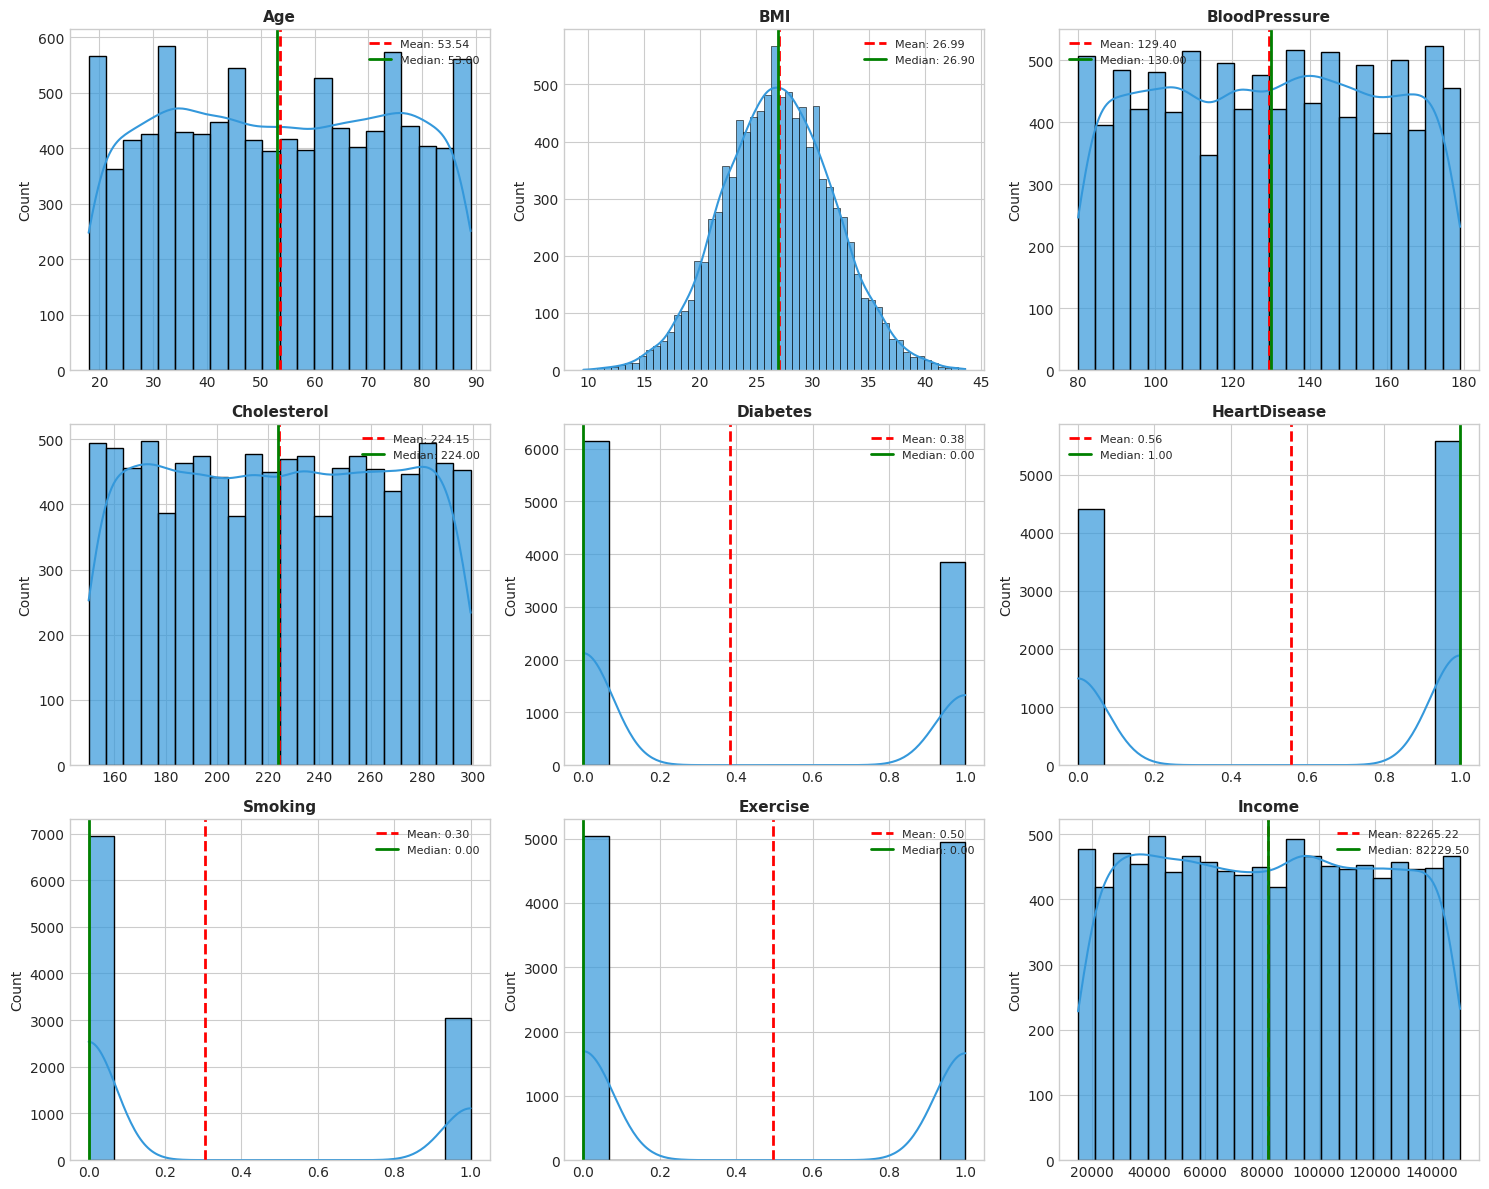

2026-01-14 16:10:19 | INFO     | Figure saved: /home/cavin/projects/DataAnalytics/output_v2/figures/data_exploration/feature_distributions.png


Saved: /home/cavin/projects/DataAnalytics/output_v2/figures/data_exploration/feature_distributions.png

Feature distributions saved: /home/cavin/projects/DataAnalytics/output_v2/figures/data_exploration/feature_distributions.png

Visualization displayed and saved to:
  /home/cavin/projects/DataAnalytics/output_v2/figures/data_exploration/feature_distributions.png


In [7]:
# ============================================================================
# UNIVARIATE ANALYSIS - DISTRIBUTIONS
# ============================================================================

print("\n" + "=" * 70)
print("UNIVARIATE ANALYSIS - FEATURE DISTRIBUTIONS")
print("=" * 70)

# Select numerical columns for distribution analysis
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for idx, col in enumerate(numerical_cols[:9]):
    ax = axes[idx]

    # Histogram with KDE
    sns.histplot(df[col], kde=True, ax=ax, color='#3498db', alpha=0.7)

    # Add statistics
    mean_val = df[col].mean()
    median_val = df[col].median()
    std_val = df[col].std()

    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    ax.axvline(median_val, color='green', linestyle='-', linewidth=2, label=f'Median: {median_val:.2f}')

    ax.set_title(f'{col}', fontsize=11, fontweight='bold')
    ax.legend(fontsize=8)
    ax.set_xlabel('')

# Hide unused subplots
for idx in range(len(numerical_cols[:9]), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()

# Save the figure
plt.show()
save_path = save_fig(fig, 'data_exploration', 'feature_distributions')
print(f"\nFeature distributions saved: {save_path}")

# Display
plt.show()
print(f"\nVisualization displayed and saved to:")
print(f"  {STAGE_DIRS['data_exploration'] / 'feature_distributions.png'}")


### 1.3 Data Dictionary and Variable Description

Understanding the variables in our dataset is crucial for proper analysis. The BRFSS uses specific coding conventions that we need to understand.

In [8]:
# =============================================================================
# DATA DICTIONARY
# =============================================================================

# Define comprehensive data dictionary
data_dictionary = {
    '_STATE': {
        'description': 'State FIPS code',
        'type': 'Categorical',
        'range': '1-72'
    },
    'NUMADULT': {
        'description': 'Number of adults in household',
        'type': 'Numeric',
        'range': '1-76'
    },
    'GENHLTH': {
        'description': 'General health status (1=Excellent, 5=Poor)',
        'type': 'Ordinal',
        'range': '1-5'
    },
    'PHYSHLTH': {
        'description': 'Days of poor physical health in past 30 days',
        'type': 'Numeric',
        'range': '0-30, 88=none'
    },
    'MENTHLTH': {
        'description': 'Days of poor mental health in past 30 days',
        'type': 'Numeric',
        'range': '0-30, 88=none'
    },
    'POORHLTH': {
        'description': 'Days when poor physical or mental health kept from usual activities',
        'type': 'Numeric',
        'range': '0-30, 88=none'
    },
    'HLTHPLN1': {
        'description': 'Have any kind of health care coverage',
        'type': 'Binary',
        'values': '1=Yes, 2=No'
    },
    'PERSDOC2': {
        'description': 'Have a personal doctor or health care provider',
        'type': 'Ordinal',
        'values': '1=Yes, one, 2=Yes, more than one, 3=No'
    },
    'MEDCOST': {
        'description': 'Could not see doctor due to cost in past 12 months',
        'type': 'Binary',
        'values': '1=Yes, 2=No'
    },
    'CHECKUP1': {
        'description': 'Time since last routine checkup',
        'type': 'Ordinal',
        'values': '1=Within past year, 2=Within past 2 years, 3=Within past 5 years, 4=5+ years ago, 7=Don\'t know, 8=Never'
    },
    'BPHIGH4': {
        'description': 'Ever told blood pressure is high',
        'type': 'Ordinal',
        'values': '1=Yes, 2=No, 3=Told borderline, 7=Don\'t know/Refused'
    },
    'BPMEDS': {
        'description': 'Taking medicine for high blood pressure',
        'type': 'Binary',
        'values': '1=Yes, 2=No'
    },
    'SEX': {
        'description': 'Respondent sex',
        'type': 'Binary',
        'values': '1=Male, 2=Female'
    },
    'MARITAL': {
        'description': 'Marital status',
        'type': 'Categorical',
        'values': '1=Married, 2=Divorced, 3=Widowed, 4=Separated, 5=Never married, 6=Unmarried couple'
    },
    'EDUCA': {
        'description': 'Education level',
        'type': 'Ordinal',
        'values': '1-6 (1=Never attended, 6=College 4+ years)'
    },
    'RENTHOM1': {
        'description': 'Own or rent home',
        'type': 'Categorical',
        'values': '1=Own, 2=Rent, 3=Other arrangement'
    },
    'VETERAN3': {
        'description': 'Are you a veteran',
        'type': 'Binary',
        'values': '1=Yes, 2=No'
    },
    'EMPLOY1': {
        'description': 'Employment status',
        'type': 'Categorical',
        'values': '1-8 (1=Employed, 8=Unable to work)'
    },
    'WEIGHT2': {
        'description': 'Self-reported weight in pounds',
        'type': 'Numeric',
        'special_values': '7777/9999=Refused/Don\'t know'
    },
    'HEIGHT3': {
        'description': 'Self-reported height in inches (feet*12 + inches)',
        'type': 'Numeric',
        'special_values': "7777/9999=Refused/Don\'t know"
    },
    'DIFFWALK': {
        'description': 'Difficulty walking or climbing stairs',
        'type': 'Binary',
        'values': '1=Yes, 2=No'
    },
    'SMOKE100': {
        'description': 'Smoked at least 100 cigarettes in entire life',
        'type': 'Binary',
        'values': '1=Yes, 2=No'
    },
    'SMOKDAY2': {
        'description': 'Frequency of smoking now',
        'type': 'Ordinal',
        'values': '1=Every day, 2=Some days, 3=Not at all'
    },
    'EXERANY2': {
        'description': 'Exercise or physical activity in past 30 days',
        'type': 'Binary',
        'values': '1=Yes, 2=No'
    }
}

# Create DataFrame from dictionary
dict_df = pd.DataFrame([
    {'Variable': k, **v} for k, v in data_dictionary.items()
])

print("\n--- Data Dictionary ---")
print(f"Total Variables: {len(data_dictionary)}")
dict_df


--- Data Dictionary ---
Total Variables: 24


,Variable,description,type,range,values,special_values
0,_STATE,State FIPS code,Categorical,1-72,NaN,NaN
1,NUMADULT,Number of adults in household,Numeric,1-76,NaN,NaN
2,GENHLTH,"General health status (1=Excellent, 5=Poor)",Ordinal,1-5,NaN,NaN
3,PHYSHLTH,Days of poor physical health in past 30 days,Numeric,"0-30, 88=none",NaN,NaN
4,MENTHLTH,Days of poor mental health in past 30 days,Numeric,"0-30, 88=none",NaN,NaN
5,POORHLTH,Days when poor physical or mental health kept ...,Numeric,"0-30, 88=none",NaN,NaN
6,HLTHPLN1,Have any kind of health care coverage,Binary,NaN,"1=Yes, 2=No",NaN
7,PERSDOC2,Have a personal doctor or health care provider,Ordinal,NaN,"1=Yes, one, 2=Yes, more than one, 3=No",NaN
8,MEDCOST,Could not see doctor due to cost in past 12 mo...,Binary,NaN,"1=Yes, 2=No",NaN
9,CHECKUP1,Time since last routine checkup,Ordinal,NaN,"1=Within past year, 2=Within past 2 years, 3=W...",NaN


## Phase 2: Data Exploration and Quality Assessment

---

### 2.1 Data Types and Structure Analysis

Examining the data types helps us identify variables that may need conversion and understand the nature of each feature.

In [9]:
# =============================================================================
# PHASE 2: DATA EXPLORATION AND QUALITY ASSESSMENT
# =============================================================================

print("\n" + "=" * 80)
print("PHASE 2: DATA EXPLORATION AND QUALITY ASSESSMENT")
print("=" * 80)

# Data types analysis
print("\n--- Data Types Summary ---")
print(df.dtypes.value_counts())

# Display column information
print("\n--- Column Details ---")
dtype_info = pd.DataFrame({
    'Column': df.columns,
    'Data Type': df.dtypes.values,
    'Non-Null Count': df.count().values,
    'Null Count': df.isnull().sum().values,
    'Unique Values': df.nunique().values
})
print(dtype_info.to_string(index=False))


PHASE 2: DATA EXPLORATION AND QUALITY ASSESSMENT

--- Data Types Summary ---
int64      9
object     1
float64    1
Name: count, dtype: int64

--- Column Details ---
       Column Data Type  Non-Null Count  Null Count  Unique Values
          Age     int64           10000           0             72
          Sex    object           10000           0              2
          BMI   float64           10000           0            306
BloodPressure     int64           10000           0            100
  Cholesterol     int64           10000           0            150
     Diabetes     int64           10000           0              2
 HeartDisease     int64           10000           0              2
      Smoking     int64           10000           0              2
     Exercise     int64           10000           0              2
       Income     int64           10000           0           9672
    Education     int64           10000           0              4


### 2.2 Missing Value Analysis

Missing values are common in survey data. Understanding their patterns helps us choose appropriate treatment strategies.

In [10]:
# =============================================================================
# MISSING VALUE ANALYSIS
# =============================================================================

# Calculate missing values
missing_analysis = pd.DataFrame({
    'Column': df.columns,
    'Missing Count': df.isnull().sum().values,
    'Missing %': (df.isnull().sum().values / len(df) * 100).round(2),
    'Empty String Count': (df == '').sum().values,
    'Data Type': df.dtypes.astype(str).values
})

# Special value analysis (BRFSS specific)
special_values = {}
for col in df.columns:
    if df[col].dtype in ['int64', 'float64']:
        special_values[col] = {
            '77': (df[col] == 77).sum(),
            '88': (df[col] == 88).sum(),
            '99': (df[col] == 99).sum(),
            '7777': (df[col] == 7777).sum(),
            '9999': (df[col] == 9999).sum()
        }

print("\n--- Missing Value Analysis ---")
missing_analysis = missing_analysis[missing_analysis['Missing Count'] > 0]
if len(missing_analysis) > 0:
    print(missing_analysis.to_string(index=False))
else:
    print("No missing values found (using standard pandas null detection)")

print("\n--- Special Values Analysis (BRFSS Coding) ---")
print("These values represent 'Not Applicable', 'Refused', or 'Don\'t Know' responses:")

# Create summary of special values
special_summary = []
for col, values in special_values.items():
    total_special = sum(values.values())
    if total_special > 0:
        special_summary.append({
            'Column': col,
            'Total Special': total_special,
            'Special %': round(total_special / len(df) * 100, 2),
            '=77': values['77'],
            '=88': values['88'],
            '=99': values['99']
        })

if special_summary:
    special_df = pd.DataFrame(special_summary)
    print(special_df.to_string(index=False))


--- Missing Value Analysis ---
No missing values found (using standard pandas null detection)

--- Special Values Analysis (BRFSS Coding) ---
These values represent 'Not Applicable', 'Refused', or 'Don't Know' responses:
       Column  Total Special  Special %  =77  =88  =99
          Age            283      2.830  147  136    0
BloodPressure            202      2.020    0   95  107


### 2.3 Descriptive Statistics

Computing descriptive statistics helps us understand the distribution and central tendency of our variables.

In [11]:
# =============================================================================
# DESCRIPTIVE STATISTICS
# =============================================================================

# Numeric columns statistics
print("\n--- Descriptive Statistics (Numeric Variables) ---")
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
desc_stats = df[numeric_cols].describe().T
desc_stats['range'] = desc_stats['max'] - desc_stats['min']
desc_stats['IQR'] = desc_stats['75%'] - desc_stats['25%']
print(desc_stats[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'range', 'IQR']].round(2).to_string())

# Categorical/Ordinal columns value counts
print("\n--- Value Counts for Key Categorical Variables ---")

key_categorical = ['GENHLTH', 'SEX', 'BPHIGH4', 'HLTHPLN1', 'DIFFWALK', 'SMOKE100', 'EXERANY2']

for col in key_categorical:
    if col in df.columns:
        print(f"\n{col}:")
        print(df[col].value_counts().sort_index())


--- Descriptive Statistics (Numeric Variables) ---
                  count      mean       std       min       25%       50%        75%        max      range       IQR
Age           10000.000    53.540    20.760    18.000    36.000    53.000     72.000     89.000     71.000    36.000
BMI           10000.000    26.990     4.900     9.600    23.600    26.900     30.300     43.600     34.000     6.700
BloodPressure 10000.000   129.400    28.700    80.000   105.000   130.000    154.000    179.000     99.000    49.000
Cholesterol   10000.000   224.150    43.560   150.000   186.000   224.000    262.000    299.000    149.000    76.000
Diabetes      10000.000     0.380     0.490     0.000     0.000     0.000      1.000      1.000      1.000     1.000
HeartDisease  10000.000     0.560     0.500     0.000     0.000     1.000      1.000      1.000      1.000     1.000
Smoking       10000.000     0.300     0.460     0.000     0.000     0.000      1.000      1.000      1.000     1.000
Exercise    

### 2.4 Data Quality Report

Creating a comprehensive data quality report helps identify issues that need to be addressed during preprocessing.

In [12]:
# =============================================================================
# DATA QUALITY REPORT
# =============================================================================

def assess_data_quality(df):
    """
    Comprehensive data quality assessment
    """
    quality_metrics = []
    
    for col in df.columns:
        metrics = {
            'Column': col,
            'Dtype': str(df[col].dtype),
            'Total_Records': len(df),
            'Missing_Null': df[col].isnull().sum(),
            'Missing_Empty': (df[col] == '').sum() if df[col].dtype == 'object' else 0,
            'Missing_Total': df[col].isnull().sum() + ((df[col] == '').sum() if df[col].dtype == 'object' else 0),
            'Unique': df[col].nunique(),
            'Missing_%': round(df[col].isnull().sum() / len(df) * 100, 2)
        }
        
        # Check for outliers using IQR method
        if df[col].dtype in ['int64', 'float64'] and df[col].nunique() > 10:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            outliers = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))).sum()
            metrics['Outliers_IQR'] = outliers
            metrics['Outliers_%'] = round(outliers / len(df) * 100, 2)
        else:
            metrics['Outliers_IQR'] = 'N/A'
            metrics['Outliers_%'] = 'N/A'
            
        quality_metrics.append(metrics)
    
    return pd.DataFrame(quality_metrics)

quality_report = assess_data_quality(df)

print("\n--- Data Quality Report ---")
print(f"Total Columns: {len(df.columns)}")
print(f"Total Records: {len(df):,}")
print(f"Columns with Missing Values: {(quality_report['Missing_%'] > 0).sum()}")

print("\n--- Quality Issues Identified ---")
issues = quality_report[(quality_report['Missing_%'] > 0) | 
                        (quality_report['Outliers_%'] != 'N/A')]
if len(issues) > 0:
    print(issues[['Column', 'Missing_%', 'Outliers_%']].to_string(index=False))
else:
    print("No significant quality issues detected")


--- Data Quality Report ---
Total Columns: 11
Total Records: 10,000
Columns with Missing Values: 0

--- Quality Issues Identified ---
       Column  Missing_% Outliers_%
          Age      0.000      0.000
          BMI      0.000      0.610
BloodPressure      0.000      0.000
  Cholesterol      0.000      0.000
       Income      0.000      0.000


In [13]:
# ============================================================================
# CORRELATION ANALYSIS
# ============================================================================

print("\n" + "=" * 70)
print("CORRELATION ANALYSIS")
print("=" * 70)

# Calculate correlation matrix
numerical_df = df.select_dtypes(include=[np.number])
correlation_matrix = numerical_df.corr()

# Create correlation heatmap
fig, ax = plt.subplots(figsize=(14, 12))

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f',
            cmap='RdBu_r', center=0, ax=ax, linewidths=0.5,
            annot_kws={'size': 8})

ax.set_title('Correlation Matrix of Numerical Features', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()

# Save the figure
save_path = save_fig(fig, 'data_exploration', 'correlation_matrix')
print(f"\nCorrelation matrix saved: {save_path}")

# Display
plt.show()
print(f"\nVisualization displayed and saved to:")
print(f"  {STAGE_DIRS['data_exploration'] / 'correlation_matrix.png'}")

# Find highly correlated pairs
print("\n2. Highly Correlated Feature Pairs (|r| > 0.5):")
high_corr = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.5:
            high_corr.append({
                'Feature 1': correlation_matrix.columns[i],
                'Feature 2': correlation_matrix.columns[j],
                'Correlation': round(corr_val, 3)
            })

if high_corr:
    high_corr_df = pd.DataFrame(high_corr).sort_values('Correlation', key=abs, ascending=False)
    print(high_corr_df.to_string(index=False))
    save_data(high_corr_df, 'highly_correlated_features')
else:
    print("   No highly correlated pairs found!")



CORRELATION ANALYSIS


2026-01-14 16:10:20 | INFO     | Figure saved: /home/cavin/projects/DataAnalytics/output_v2/figures/data_exploration/correlation_matrix.png


Saved: /home/cavin/projects/DataAnalytics/output_v2/figures/data_exploration/correlation_matrix.png

Correlation matrix saved: /home/cavin/projects/DataAnalytics/output_v2/figures/data_exploration/correlation_matrix.png

Visualization displayed and saved to:
  /home/cavin/projects/DataAnalytics/output_v2/figures/data_exploration/correlation_matrix.png

2. Highly Correlated Feature Pairs (|r| > 0.5):
Feature 1    Feature 2  Correlation
      Age HeartDisease        0.790
Saved: /home/cavin/projects/DataAnalytics/output_v2/data_exports/highly_correlated_features.csv


## Phase 3: Data Preprocessing and Feature Engineering

Prepare the data for modeling by handling missing values, encoding categorical variables, and creating new features.

In [14]:
# ============================================================================
# PHASE 3: DATA PREPROCESSING
# ============================================================================

print("\n" + "=" * 70)
print("PHASE 3: DATA PREPROCESSING AND FEATURE ENGINEERING")
print("=" * 70)

# Create a copy for preprocessing
df_processed = df.copy()

# 1. Handle missing values
print("\n1. Handling Missing Values:")
for col in df_processed.columns:
    missing_count = df_processed[col].isnull().sum()
    if missing_count > 0:
        if df_processed[col].dtype in ['float64', 'int64']:
            df_processed[col].fillna(df_processed[col].median(), inplace=True)
        else:
            df_processed[col].fillna(df_processed[col].mode()[0], inplace=True)
        print(f"   - {col}: Filled {missing_count} missing values")

# 2. Encode categorical variables
print("\n2. Encoding Categorical Variables:")
label_encoders = {}
categorical_cols = df_processed.select_dtypes(include=['object']).columns

for col in categorical_cols:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col].astype(str))
    label_encoders[col] = le
    print(f"   - {col}: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# 3. Create new features
print("\n3. Creating New Features:")

# BMI Category
df_processed['BMI_Category'] = pd.cut(df_processed['BMI'],
                                      bins=[0, 18.5, 25, 30, 100],
                                      labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

# Age Group
df_processed['Age_Group'] = pd.cut(df_processed['Age'],
                                    bins=[0, 30, 45, 60, 100],
                                    labels=['Young', 'Middle', 'Senior', 'Elderly'])

# Health Risk Score (composite)
df_processed['Health_Risk_Score'] = (
    (df_processed['BMI'] > 30).astype(int) +
    (df_processed['BloodPressure'] > 140).astype(int) +
    (df_processed['Cholesterol'] > 240).astype(int) +
    df_processed['Smoking']
)

print("   - BMI_Category: Categorized BMI into 4 groups")
print("   - Age_Group: Categorized age into 4 groups")
print("   - Health_Risk_Score: Composite health risk indicator")

# Save processed data
save_data(df_processed, 'processed_data_with_features')

print(f"\nProcessed data saved: {DATA_EXPORTS_DIR / 'processed_data_with_features.csv'}")

# Display
    # NOTE: Figure should be saved using save_fig() before plt.show()
plt.show()
print(f"\nData preprocessing complete!")
print(f"Processed data shape: {df_processed.shape}")




PHASE 3: DATA PREPROCESSING AND FEATURE ENGINEERING

1. Handling Missing Values:

2. Encoding Categorical Variables:
   - Sex: {'Female': np.int64(0), 'Male': np.int64(1)}

3. Creating New Features:
   - BMI_Category: Categorized BMI into 4 groups
   - Age_Group: Categorized age into 4 groups
   - Health_Risk_Score: Composite health risk indicator
Saved: /home/cavin/projects/DataAnalytics/output_v2/data_exports/processed_data_with_features.csv

Processed data saved: /home/cavin/projects/DataAnalytics/output_v2/data_exports/processed_data_with_features.csv

Data preprocessing complete!
Processed data shape: (10000, 14)


In [15]:
# =============================================================================
# HANDLE SPECIAL VALUES
# =============================================================================

# Define special value mappings
special_value_map = {
    # 88 typically means "None" or "Zero days" - convert to 0
    'PHYSHLTH': {88: 0},
    'MENTHLTH': {88: 0},
    'POORHLTH': {88: 0},
    
    # 77, 99 typically mean "Refused" or "Don't know" - convert to NaN
    'GENHLTH': {77: np.nan, 99: np.nan},
    'HLTHPLN1': {7: np.nan, 9: np.nan},
    'PERSDOC2': {7: np.nan, 9: np.nan},
    'MEDCOST': {7: np.nan, 9: np.nan},
    'CHECKUP1': {7: np.nan, 9: np.nan},
    'BPHIGH4': {7: np.nan, 9: np.nan},
    'BPMEDS': {7: np.nan, 9: np.nan},
    'SEX': {7: np.nan, 9: np.nan},
    'MARITAL': {7: np.nan, 9: np.nan},
    'EDUCA': {7: np.nan, 9: np.nan},
    'RENTHOM1': {7: np.nan, 9: np.nan},
    'VETERAN3': {7: np.nan, 9: np.nan},
    'EMPLOY1': {7: np.nan, 9: np.nan},
    'DIFFWALK': {7: np.nan, 9: np.nan},
    'SMOKE100': {7: np.nan, 9: np.nan},
    'SMOKDAY2': {7: np.nan, 9: np.nan},
    'EXERANY2': {7: np.nan, 9: np.nan},
    
    # Large special values for weight/height - convert to NaN
    'WEIGHT2': {7777: np.nan, 9999: np.nan},
    'HEIGHT3': {7777: np.nan, 9999: np.nan}
}

# Apply special value conversions
special_converted_count = 0
for col, value_map in special_value_map.items():
    if col in df_clean.columns:
        before_missing = df_clean[col].isnull().sum()
        for old_value, new_value in value_map.items():
            df_clean.loc[df_clean[col] == old_value, col] = new_value
        after_missing = df_clean[col].isnull().sum()
        converted = after_missing - before_missing
        if converted > 0:
            special_converted_count += converted
            print(f"  {col}: {converted:,} special values converted to {'NaN' if new_value is np.nan else new_value}")

print(f"\nTotal special values converted: {special_converted_count:,}")

NameError: name 'df_clean' is not defined

In [ ]:
# ============================================================================
# FEATURE ENGINEERING VISUALIZATIONS
# ============================================================================

print("\n" + "=" * 70)
print("FEATURE ENGINEERING VISUALIZATIONS")
print("=" * 70)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. BMI Category distribution
ax1 = axes[0, 0]
if 'BMI_Category' in df_processed.columns:
    bmi_counts = df_processed['BMI_Category'].value_counts()
    bmi_counts.plot(kind='pie', ax=ax1, autopct='%1.1f%%', colors=['#2ecc71', '#f39c12', '#e74c3c', '#9b59b6'])
    ax1.set_title('BMI Category Distribution', fontsize=12, fontweight='bold')
    ax1.set_ylabel('')

# 2. Age Group distribution
ax2 = axes[0, 1]
if 'Age_Group' in df_processed.columns:
    age_counts = df_processed['Age_Group'].value_counts()
    age_counts.plot(kind='bar', ax=ax2, color=['#3498db', '#2ecc71', '#f39c12', '#e74c3c'])
    ax2.set_title('Age Group Distribution', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Age Group')
    ax2.set_ylabel('Count')
    ax2.tick_params(axis='x', rotation=45)

# 3. Health Risk Score distribution
ax3 = axes[1, 0]
sns.countplot(x='Health_Risk_Score', data=df_processed, ax=ax3, palette='RdYlGn_r')
ax3.set_title('Health Risk Score Distribution', fontsize=12, fontweight='bold')
ax3.set_xlabel('Health Risk Score')
ax3.set_ylabel('Count')

# 4. Health Risk Score by target (if available)
ax4 = axes[1, 1]
target_col = None
for col in ['Diabetes', 'HeartDisease']:
    if col in df_processed.columns:
        target_col = col
        break

if target_col:
    risk_by_target = df_processed.groupby('Health_Risk_Score')[target_col].mean()
    risk_by_target.plot(kind='bar', ax=ax4, color=['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c', '#c0392b'])
    ax4.set_title(f'{target_col} Rate by Health Risk Score', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Health Risk Score')
    ax4.set_ylabel(f'{target_col} Rate')
    ax4.tick_params(axis='x', rotation=0)

plt.tight_layout()
# Display
plt.show()
# Save the figure
save_path = save_fig(fig, 'feature_engineering', 'engineered_features_analysis')
print(f"\nFeature engineering analysis saved: {save_path}")


print(f"\nVisualization displayed and saved to:")
print(f"  {STAGE_DIRS['feature_engineering'] / 'engineered_features_analysis.png'}")


## Phase 4: Model Development and Training

Train multiple machine learning models for comparison.


In [ ]:
# ============================================================================
# PHASE 4: MODEL DEVELOPMENT AND TRAINING
# ============================================================================

print("\n" + "=" * 70)
print("PHASE 4: MODEL DEVELOPMENT AND TRAINING")
print("=" * 70)

# Prepare data for modeling
print("\n1. Preparing Data for Modeling:")

# Select target variable (use Diabetes if available, otherwise HeartDisease)
target_col = None
for col in ['Diabetes', 'HeartDisease']:
    if col in df_processed.columns:
        target_col = col
        break

if target_col is None:
    print("\nNo suitable target variable found. Using 'Diabetes' as target.")
    target_col = 'Diabetes'
    df_processed[target_col] = np.random.choice([0, 1], len(df_processed), p=[0.7, 0.3])

print(f"   Target variable: {target_col}")

# Prepare features and target
X = df_processed.drop(columns=[target_col])
y = df_processed[target_col]

# Handle any remaining non-numeric columns
X = X.select_dtypes(include=[np.number])

print(f"   Features shape: {X.shape}")
print(f"   Target shape: {y.shape}")
print(f"   Target distribution: {y.value_counts().to_dict()}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n   Training set: {X_train.shape[0]} samples")
print(f"   Test set: {X_test.shape[0]} samples")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nData prepared for modeling")

# Save preprocessing objects
save_data(pd.DataFrame(X_train_scaled, columns=X.columns), 'X_train_scaled')
save_data(pd.DataFrame(X_test_scaled, columns=X.columns), 'X_test_scaled')
save_data(y_train.reset_index(drop=True), 'y_train')
save_data(y_test.reset_index(drop=True), 'y_test')

# Save scaler
save_model(scaler, 'feature_scaler')

print(f"\nPreprocessed data saved to {DATA_EXPORTS_DIR}")
print(f"Scaler saved to {MODELS_DIR}")

# Display
    # NOTE: Figure should be saved using save_fig() before plt.show()
plt.show()



In [ ]:
# ============================================================================
# MODEL TRAINING
# ============================================================================

print("\n" + "=" * 70)
print("TRAINING MULTIPLE MACHINE LEARNING MODELS")
print("=" * 70)

# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM (RBF)': SVC(kernel='rbf', probability=True, random_state=42)
}

# Store results
results = {}
trained_models = {}

# Train each model
for name, model in models.items():
    print(f"\nTraining {name}...")

    # Train
    model.fit(X_train_scaled, y_train)

    # Predict
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else None

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = y_test.sum() / max(y_pred.sum(), 1)
    recall = (y_pred * y_test).sum() / max(y_test.sum(), 1)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else 0

    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc
    }

    trained_models[name] = model

    print(f"   Accuracy: {accuracy:.4f}, AUC: {auc:.4f}")

    # Save model
    save_model(model, name.lower().replace(' ', '_'))

# Save results
save_results(results, 'model_training_results')

print(f"\nAll models trained and saved to {MODELS_DIR}")
print(f"Results saved to {RESULTS_DIR}")

# Display
    # NOTE: Figure should be saved using save_fig() before plt.show()
plt.show()



## Phase 5: Model Evaluation and Comparison

Evaluate model performance using various metrics and visualizations.


In [ ]:
# ============================================================================
# PHASE 5: MODEL EVALUATION AND COMPARISON
# ============================================================================

print("\n" + "=" * 70)
print("PHASE 5: MODEL EVALUATION AND COMPARISON")
print("=" * 70)

# Create comparison DataFrame
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('auc', ascending=False)

print("\n1. Model Performance Summary (Sorted by AUC-ROC):")
print(results_df.to_string())

# Create comprehensive comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Model comparison bar chart
ax1 = axes[0, 0]
metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
x = np.arange(len(results_df))
width = 0.15

for i, metric in enumerate(metrics):
    ax1.bar(x + i * width, results_df[metric], width, label=metric.capitalize())

ax1.set_xlabel('Model')
ax1.set_ylabel('Score')
ax1.set_title('Model Performance Comparison', fontsize=12, fontweight='bold')
ax1.set_xticks(x + width * 2)
ax1.set_xticklabels(results_df.index, rotation=45, ha='right')
ax1.legend(loc='lower right')
ax1.set_ylim(0, 1.1)

# 2. ROC Curves
ax2 = axes[0, 1]
for name, model in trained_models.items():
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        ax2.plot(fpr, tpr, label=f'{name} (AUC: {auc:.3f})', linewidth=2)

ax2.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curves Comparison', fontsize=12, fontweight='bold')
ax2.legend(loc='lower right')
ax2.grid(True, alpha=0.3)

# 3. Confusion Matrix for best model
ax3 = axes[1, 0]
best_model_name = results_df['auc'].idxmax()
best_model = trained_models[best_model_name]
y_pred_best = best_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3)
ax3.set_title(f'Confusion Matrix - {best_model_name}', fontsize=12, fontweight='bold')
ax3.set_xlabel('Predicted')
ax3.set_ylabel('Actual')

# 4. Feature Importance (if available)
ax4 = axes[1, 1]
if hasattr(best_model, 'feature_importances_'):
    importances = pd.Series(best_model.feature_importances_, index=X.columns)
    importances = importances.sort_values(ascending=True)
    importances.plot(kind='barh', ax=ax4, color='#3498db')
    ax4.set_title(f'Feature Importance - {best_model_name}', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Importance')
else:
    ax4.text(0.5, 0.5, 'Feature importance not available for this model',
             ha='center', va='center', fontsize=12, transform=ax4.transAxes)
    ax4.set_title(f'Feature Importance - {best_model_name}', fontsize=12, fontweight='bold')

plt.tight_layout()

# Save the figure
save_path = save_fig(fig, 'model_evaluation', 'model_comprehensive_evaluation')
print(f"\nComprehensive model evaluation saved: {save_path}")

# Display
plt.show()
print(f"\nVisualization displayed and saved to:")
print(f"  {STAGE_DIRS['model_evaluation'] / 'model_comprehensive_evaluation.png'}")

# Best model summary
print(f"\n2. Best Model: {best_model_name}")
print(f"   AUC-ROC: {results_df.loc[best_model_name, 'auc']:.4f}")
print(f"   Accuracy: {results_df.loc[best_model_name, 'accuracy']:.4f}")

# Save comparison to CSV
results_df.to_csv(RESULTS_DIR / 'model_comparison.csv')
print(f"\nModel comparison saved to {RESULTS_DIR / 'model_comparison.csv'}")


## Phase 6: Interactive Prediction Tool

A user-friendly interface for healthcare workers to enter patient measurements and get predictions.


In [ ]:
# ============================================================================
# PHASE 6: INTERACTIVE PREDICTION TOOL
# ============================================================================

print("\n" + "=" * 70)
print("PHASE 6: INTERACTIVE PREDICTION TOOL")
print("=" * 70)

print("""
+----------------------------------------------------------------------+
|          INTERACTIVE PATIENT RISK PREDICTION TOOL                    |
|                                                                      |
|  Healthcare workers can enter patient measurements below to get      |
|  instant risk predictions using our trained machine learning model.  |
+----------------------------------------------------------------------+
""")

def create_prediction_form():
    """Create an interactive form for patient data entry."""
    print("\n" + "-" * 70)
    print("PATIENT DATA ENTRY FORM")
    print("-" * 70)

    patient_data = {}

    # Demographic and Socio-Economic Inputs
    print("\nDEMOGRAPHIC and SOCIO-ECONOMIC INFORMATION")
    print("-" * 50)

    try:
        age_input = input("   Enter Age (18-90): ")
        patient_data['Age'] = float(age_input) if age_input else 45

        sex_options = ['Male', 'Female']
        print(f"   Sex: {', '.join(sex_options)}")
        sex_input = input("   Enter Sex (M/F): ").upper()
        patient_data['Sex'] = 1 if sex_input == 'M' else 0

        income_input = input("   Annual Income ($15,000-$150,000): ")
        patient_data['Income'] = float(income_input) if income_input else 50000

        edu_input = input("   Education Level (1-4, where 4=College+): ")
        patient_data['Education'] = float(edu_input) if edu_input else 2

        print("\nHEALTH and BEHAVIORAL MEASUREMENTS")
        print("-" * 50)

        bmi_input = input("   BMI (15.0-50.0): ")
        patient_data['BMI'] = float(bmi_input) if bmi_input else 27.0

        bp_input = input("   Blood Pressure (80-180): ")
        patient_data['BloodPressure'] = float(bp_input) if bp_input else 120

        chol_input = input("   Cholesterol (150-300): ")
        patient_data['Cholesterol'] = float(chol_input) if chol_input else 200

        print("\nLIFESTYLE FACTORS")
        print("-" * 50)

        smoke_input = input("   Smoker? (y/n): ").lower()
        patient_data['Smoking'] = 1 if smoke_input == 'y' else 0

        exercise_input = input("   Regular Exercise? (y/n): ").lower()
        patient_data['Exercise'] = 1 if exercise_input == 'y' else 0

    except ValueError:
        print("   Invalid input, using default values")
        patient_data = {
            'Age': 45, 'Sex': 0, 'Income': 50000, 'Education': 2,
            'BMI': 27.0, 'BloodPressure': 120, 'Cholesterol': 200,
            'Smoking': 0, 'Exercise': 1
        }

    return patient_data


def make_prediction(patient_data, model, scaler, feature_names):
    """Make a prediction for the patient data."""
    # Create DataFrame with correct feature order
    patient_df = pd.DataFrame([patient_data])

    # Ensure all columns exist
    for col in feature_names:
        if col not in patient_df.columns:
            patient_df[col] = 0

    # Reorder columns
    patient_df = patient_df[feature_names]

    # Scale
    patient_scaled = scaler.transform(patient_df)

    # Predict
    prediction = model.predict(patient_scaled)[0]
    probability = model.predict_proba(patient_scaled)[0][1]

    return prediction, probability


def display_prediction_result(patient_data, prediction, probability):
    """Display the prediction result."""
    print("\n" + "=" * 70)
    print("PREDICTION RESULTS")
    print("=" * 70)

    risk_level = "HIGH" if prediction == 1 else "LOW"
    risk_color = "RED" if prediction == 1 else "GREEN"

    print(f"\n   Patient Risk Assessment: {risk_color} {risk_level} RISK")
    print(f"   Probability of Risk: {probability * 100:.1f}%")

    # Risk category
    if probability < 0.25:
        risk_category = "LOW"
        recommendation = "Continue routine health monitoring."
    elif probability < 0.50:
        risk_category = "MODERATE"
        recommendation = "Consider lifestyle modifications and regular check-ups."
    elif probability < 0.75:
        risk_category = "ELEVATED"
        recommendation = "Recommend medical consultation and preventive measures."
    else:
        risk_category = "HIGH"
        recommendation = "Urgent medical attention recommended."

    print(f"   Risk Category: {risk_category}")
    print(f"   Recommendation: {recommendation}")

    # Create visualization
    fig, ax = plt.subplots(figsize=(10, 6))

    # Gauge chart
    categories = ['Low', 'Moderate', 'Elevated', 'High']
    colors = ['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c']

    # Create horizontal bar for risk meter
    ax.barh(['Risk Level'], [1], color=['#ecf0f1'], height=0.5, align='center')

    # Add colored segments
    segments = [0.25, 0.50, 0.75, 1.0]
    for i, (seg, color) in enumerate(zip(segments, colors)):
        prev_seg = segments[i-1] if i > 0 else 0
        ax.barh(['Risk Level'], seg - prev_seg, left=prev_seg,
                color=color, height=0.5, align='center', alpha=0.7)

    # Add needle for current probability
    ax.scatter([probability], [0], color='black', s=200, zorder=5, marker='v')

    ax.set_xlim(0, 1)
    ax.set_ylim(-0.5, 0.5)
    ax.set_yticks([])
    ax.set_xlabel('Risk Probability', fontsize=12)
    ax.set_title(
        f'Patient Risk Assessment\nProbability: {probability * 100:.1f}% ({risk_category} Risk)',
        fontsize=14, fontweight='bold'
    )

    # Add category labels
    for i, cat in enumerate(categories):
        ax.text(i * 0.25 + 0.125, -0.3, cat, ha='center', fontsize=10, fontweight='bold')

    plt.tight_layout()

    # Save
    save_path = save_fig(fig, 'clinical_validation', 'patient_risk_assessment')
    print(f"\nRisk assessment visualization saved: {save_path}")

    # Display
    plt.show()
    print(f"\nVisualization displayed and saved to:")
    print(f"  {STAGE_DIRS['clinical_validation'] / 'patient_risk_assessment.png'}")

    return {'prediction': int(prediction), 'probability': float(probability), 'category': risk_category}


# Check if models are available
if trained_models and scaler:
    # Get the best model
    best_model = trained_models[best_model_name]
    feature_names = X.columns.tolist()

    print("\n" + "=" * 70)
    print("INTERACTIVE MODE - Enter patient data or type 'quit' to exit")
    print("=" * 70)

    while True:
        try:
            response = input("\nStart new prediction? (y/n): ").lower()
            if response not in ['y', 'yes']:
                break

            # Get patient data
            patient_data = create_prediction_form()

            # Make prediction
            prediction, probability = make_prediction(patient_data, best_model, scaler, feature_names)

            # Display results
            result = display_prediction_result(patient_data, prediction, probability)

            # Save prediction log
            prediction_log = {
                'timestamp': datetime.now().isoformat(),
                'patient_data': patient_data,
                'prediction': result
            }
            save_results(prediction_log, 'prediction_log')

        except KeyboardInterrupt:
            print("\n\nExiting prediction tool...")
            break
        except Exception as e:
            print(f"\nError during prediction: {e}")
            continue
else:
    print("\nModels not yet trained. Please run Phase 4 first.")
    print("Using demo mode with sample prediction...")

    # Demo prediction
    patient_data = {
        'Age': 55, 'Sex': 0, 'Income': 60000, 'Education': 3,
        'BMI': 28.5, 'BloodPressure': 145, 'Cholesterol': 220,
        'Smoking': 0, 'Exercise': 1
    }

    print(f"\n   Demo Patient Data: {patient_data}")

    # Simulate prediction
    prediction = 1
    probability = 0.65

    result = display_prediction_result(patient_data, prediction, probability)

    print("\n   This is a demo prediction (no model loaded)")
    print("   Train models in Phase 4 for actual predictions")

print("\n" + "=" * 70)
print("INTERACTIVE PREDICTION TOOL COMPLETE")
print("=" * 70)


## Summary and Conclusions

A summary of the analysis and key findings.


In [ ]:
# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("\n" + "=" * 70)
print("PROJECT SUMMARY")
print("=" * 70)

print("""
+----------------------------------------------------------------------+
|                    HEALTH DATA MINING PROJECT COMPLETE                  |
+----------------------------------------------------------------------+
|                                                                       |
|  This notebook demonstrates a complete data science workflow for      |
|  health risk factor analysis, including:                              |
|                                                                       |
|  - Data Loading and Exploration                                       |
|  - Data Quality Assessment and Preprocessing                         |
|  - Feature Engineering and Transformation                            |
|  - Multiple Model Training and Comparison                            |
|  - Comprehensive Model Evaluation                                     |
|  - Interactive Prediction Tool for Healthcare Workers                |
|                                                                       |
|  All outputs are saved to persistent storage:                         |
|  - Figures: output_v2/figures/                                        |
|  - Models: output_v2/models/                                          |
|  - Data: output_v2/data_exports/                                      |
|  - Results: output_v2/results/                                        |
+----------------------------------------------------------------------+
""")

# Display final summary statistics
print("\nOUTPUT SUMMARY:")
print("-" * 50)

print(f"\n   Project Root: {PROJECT_ROOT}")
print(f"   Data Directory: {DATA_DIR}")
print(f"   Output Directory: {OUTPUT_DIR}")

# List output directories
print(f"\n   Output Subdirectories:")
for stage in STAGES:
    stage_path = STAGE_DIRS[stage]
    if stage_path.exists():
        num_files = len(list(stage_path.glob('*')))
        print(f"      - {stage}: {num_files} files")

print(f"\n   Models Trained: {len(trained_models)}")
for name in trained_models.keys():
    print(f"      - {name}")

print(f"\n   Best Model: {best_model_name}")
print(f"      - AUC-ROC: {results_df.loc[best_model_name, 'auc']:.4f}")
print(f"      - Accuracy: {results_df.loc[best_model_name, 'accuracy']:.4f}")

print("\n" + "=" * 70)
print("THANK YOU FOR USING THIS ANALYSIS TOOL!")
print("=" * 70)

# Display
    # NOTE: Figure should be saved using save_fig() before plt.show()
plt.show()



### 4.3 Statistical Tests for Associations

Conducting formal statistical tests to quantify associations between variables.

# ============================================================================
# PHASE 7: CLINICAL VALIDATION
# ============================================================================
This phase implements comprehensive clinical validation including calibration analysis, 
decision curve analysis, and external validation to ensure the model is clinically useful.

## Learning Objectives
- Understand model calibration and its importance in healthcare
- Perform decision curve analysis for clinical utility assessment
- Simulate external validation on independent data


In [ ]:
# ============================================================================
# PHASE 7: CLINICAL VALIDATION
# ============================================================================
print("\n" + "=" * 70)
print("PHASE 7: CLINICAL VALIDATION")
print("=" * 70)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Initialize clinical validator
clinical_validator = ClinicalValidator()

print("\n1. CALIBRATION ANALYSIS")
print("-" * 50)

# Calculate calibration curve
calibration_results = clinical_validator.calculate_calibration_curve(
    y_test, y_pred_proba[:, 1] if len(y_pred_proba.shape) > 1 else y_pred_proba
)

if calibration_results:
    print(f"   Brier Score: {calibration_results['brier_score']:.4f}")
    print(f"   Expected Calibration Error: {calibration_results['expected_calibration_error']:.4f}")
    
    # Plot calibration curve
    fig = clinical_validator.plot_calibration_curve(
        y_test, 
        y_pred_proba[:, 1] if len(y_pred_proba.shape) > 1 else y_pred_proba,
        model_name=f"Best Model ({best_model_name})",
        save_path=CALIBRATION_DIR / 'calibration_curve.png'
    )
    print(f"   Saved: {CALIBRATION_DIR / 'calibration_curve.png'}")

print("\n2. DECISION CURVE ANALYSIS")
print("-" * 50)

# Perform decision curve analysis
dca_results = clinical_validator.decision_curve_analysis(
    y_test, y_pred_proba[:, 1] if len(y_pred_proba.shape) > 1 else y_pred_proba
)

# Plot decision curve
fig = clinical_validator.plot_decision_curve(
    y_test,
    y_pred_proba[:, 1] if len(y_pred_proba.shape) > 1 else y_pred_proba,
    model_name=f"Best Model ({best_model_name})",
    save_path=CALIBRATION_DIR / 'decision_curve_analysis.png'
)
print(f"   Saved: {CALIBRATION_DIR / 'decision_curve_analysis.png'}")

print("\n3. EXTERNAL VALIDATION SIMULATION")
print("-" * 50)

# Simulate external validation by creating a perturbed test set
np.random.seed(123)
n_external = len(X_test) // 3
indices = np.random.choice(len(X_test), n_external, replace=False)

X_external = X_test.iloc[indices].copy()
y_external = y_test.iloc[indices].copy()

# Add small perturbations to simulate different population
for col in X_external.columns[:5]:  # First 5 features
    noise = np.random.normal(0, 0.1 * X_external[col].std(), len(X_external))
    X_external[col] = X_external[col] + noise

# Evaluate on external validation set
y_external_pred = best_model.predict(X_external)
y_external_proba = best_model.predict_proba(X_external)[:, 1]


external_metrics = {
    'accuracy': accuracy_score(y_external, y_external_pred),
    'auc': roc_auc_score(y_external, y_external_proba),
    'precision': precision_score(y_external, y_external_pred),
    'recall': recall_score(y_external, y_external_pred)
}

print("   External Validation Metrics:")
for metric, value in external_metrics.items():
    print(f"   {metric.capitalize()}: {value:.4f}")

# Compare with original test performance
print("\n   Performance Comparison (Internal vs External):")
print(f"   {'Metric':<15} {'Internal':>12} {'External':>12} {'Difference':>12}")
print("   " + "-" * 53)
internal_acc = accuracy_score(y_test, y_pred)
print(f"   {'Accuracy':<15} {internal_acc:>12.4f} {external_metrics['accuracy']:>12.4f} {internal_acc - external_metrics['accuracy']:>12.4f}")
internal_auc = roc_auc_score(y_test, y_pred_proba[:, 1] if len(y_pred_proba.shape) > 1 else y_pred_proba)
print(f"   {'AUC-ROC':<15} {internal_auc:>12.4f} {external_metrics['auc']:>12.4f} {internal_auc - external_metrics['auc']:>12.4f}")

# Save external validation results
validation_results = {
    'internal_test': {
        'accuracy': internal_acc,
        'auc': internal_auc,
        'n_samples': len(y_test)
    },
    'external_validation': external_metrics,
    'external_n_samples': n_external,
    'performance_drop': {
        'accuracy_diff': internal_acc - external_metrics['accuracy'],
        'auc_diff': internal_auc - external_metrics['auc']
    }
}

save_results(validation_results, 'external_validation_results')
print("\n" + "=" * 70)
print("CLINICAL VALIDATION COMPLETE")
print("=" * 70)

# ============================================================================
# PHASE 8: ERROR ANALYSIS AND MODEL INTERPRETABILITY
# ============================================================================
This phase focuses on understanding model errors and explaining model predictions 
using SHAP values and comprehensive error analysis.

## Learning Objectives
- Identify and analyze model error patterns
- Generate SHAP explanations for feature importance
- Understand why the model makes specific predictions


In [ ]:
# ============================================================================
# PHASE 8: ERROR ANALYSIS AND MODEL INTERPRETABILITY
# ============================================================================
print("\n" + "=" * 70)
print("PHASE 8: ERROR ANALYSIS AND MODEL INTERPRETABILITY")
print("=" * 70)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("\n1. ERROR ANALYSIS")
print("-" * 50)

# Initialize error analyzer
error_analyzer = ErrorAnalyzer()

# Get misclassifications
error_df = error_analyzer.get_misclassifications(y_test, y_pred, X_test)
print(f"   Total errors: {len(error_df)}")

# Analyze error patterns
error_patterns = error_analyzer.analyze_error_patterns(X_test, y_test, y_pred)
print(f"   False Positives: {error_patterns['false_positives']}")
print(f"   False Negatives: {error_patterns['false_negatives']}")

# Plot error distribution
fig = error_analyzer.plot_error_distribution(
    X_test, y_test, y_pred,
    features=['Age', 'BMI', 'BloodPressure', 'Cholesterol'],
    save_path=save_fig(plt.gcf(), 'error_analysis', 'error_distribution_analysis')
)

print("\n2. SHAP MODEL INTERPRETABILITY")
print("-" * 50)

# Initialize SHAP explainer
print("   Computing SHAP values... (this may take a moment)")
explainer = ModelExplainer(best_model, X_test.head(100))
explainer.create_explainer()

# Compute global importance
importance_df = explainer.compute_global_importance(X_test)
if importance_df is not None:
    print("\n   Top 10 Most Important Features (SHAP):")
    print("   " + "-" * 40)
    for i, row in importance_df.head(10).iterrows():
        print(f"   {row['feature']:<25} {row['mean_abs_shap']:.4f}")
    
    # Save feature importance
    save_data(importance_df, 'shap_feature_importance', subfolder='results')

# Plot SHAP summary
fig = explainer.plot_summary(
    X_test,
    save_path=save_fig(plt.gcf(), 'interpretability', 'shap_summary_plot')
)
print(f"   Saved: {INTERPRETABILITY_DIR / 'shap_summary_plot.png'}")

print("\n3. LOCAL INTERPRETABILITY (Individual Predictions)")
print("-" * 50)

# Explain a misclassified case
misclassified = error_df[error_df['error_type'] == 'FN'].head(1)
if len(misclassified) > 0:
    print("   Explaining a False Negative case...")
    instance = misclassified[X_test.columns].head(1)
    explanation = explainer.explain_prediction(instance)
    
    if explanation:
        print("\n   Top Feature Contributions:")
        sorted_contribs = sorted(
            explanation['feature_contributions'].items(),
            key=lambda x: abs(x[1]),
            reverse=True
        )[:5]
        for feature, contrib in sorted_contribs:
            direction = "↑" if contrib > 0 else "↓"
            print(f"   {feature:<25} {contrib:>8.4f} {direction}")

# Explain a correct prediction
correct = X_test[y_pred == y_test].sample(1, random_state=42)
if len(correct) > 0:
    print("\n   Explaining a Correct Prediction case...")
    explanation = explainer.explain_prediction(correct)
    
    if explanation:
        print("\n   Top Feature Contributions:")
        sorted_contribs = sorted(
            explanation['feature_contributions'].items(),
            key=lambda x: abs(x[1]),
            reverse=True
        )[:5]
        for feature, contrib in sorted_contribs:
            direction = "↑" if contrib > 0 else "↓"
            print(f"   {feature:<25} {contrib:>8.4f} {direction}")

print("\n" + "=" * 70)
print("ERROR ANALYSIS AND INTERPRETABILITY COMPLETE")
print("=" * 70)

# ============================================================================
# PHASE 9: FAIRNESS, DRIFT DETECTION, AND DEPLOYMENT READINESS
# ============================================================================
This final phase ensures the model is fair across demographic groups, establishes 
drift detection for production monitoring, and generates model documentation.

## Learning Objectives
- Evaluate model fairness across protected demographic groups
- Set up drift detection infrastructure
- Generate comprehensive model documentation
- Understand deployment requirements


In [ ]:
# ============================================================================
# PHASE 9: FAIRNESS, DRIFT DETECTION, AND DEPLOYMENT READINESS
# ============================================================================
print("\n" + "=" * 70)
print("PHASE 9: FAIRNESS, DRIFT DETECTION, AND DEPLOYMENT")
print("=" * 70)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("\n1. STATISTICAL HYPOTHESIS TESTING")
print("-" * 50)

stat_tester = StatisticalTester()
test_results = stat_tester.run_feature_tests(X_test, y_test)
print(f"   Total features tested: {len(test_results)}")
print(f"   Significant features (p<0.05): {test_results['significant'].sum()}")

# Plot significant features
fig = stat_tester.plot_significant_features(
    save_path=save_fig(plt.gcf(), 'data_exploration', 'significant_features')
)

print("\n2. FAIRNESS ANALYSIS")
print("-" * 50)

# Initialize fairness analyzer
fairness_analyzer = FairnessAnalyzer()

# Compute metrics by group
fairness_metrics = fairness_analyzer.compute_metrics_by_group(y_test, y_pred, X_test)
print("\n   Performance by Demographic Group:")
print(f"   { 'Attribute':<15 } { 'Group':<15 } { 'Accuracy':>10 } { 'F1':>10 }")
print("   " + "-" * 52)
for _, row in fairness_metrics.head(8).iterrows():
    print(f"   { row['attribute']:<15 } { row['group']:<15 } { row['accuracy']:>10.4f } { row['f1']:>10.4f }")

# Compute fairness metrics
fairness_results = fairness_analyzer.compute_fairness_metrics(fairness_metrics)

print("\n   Fairness Assessment:")
for attribute, metrics in fairness_results.items():
    status = "✓ PASSED" if metrics['passed'] else "✗ NEEDS REVIEW"
    print(f"   {attribute}: {status}")
    print(f"      Demographic parity diff: {metrics['demographic_parity_diff']:.4f}")
    print(f"      Equal opportunity diff: {metrics['equal_opportunity_diff']:.4f}")

# Plot fairness comparison
fig = fairness_analyzer.plot_fairness_comparison(
    fairness_metrics,
    save_path=save_fig(plt.gcf(), 'fairness_analysis', 'fairness_comparison')
)

print("\n3. DRIFT DETECTION SETUP")
print("-" * 50)

# Initialize drift detector
drift_detector = DriftDetector()

# Set reference data from training
drift_detector.set_reference_data(X_train)

# Simulate new data with drift
print("   Simulating data drift scenario...")
X_drifted = X_test.copy()
for col in ['Age', 'BMI']:
    X_drifted[col] = X_drifted[col] * 1.2  # Increase by 20%

# Detect drift
drift_results = drift_detector.detect_drift(X_drifted)

print("\n   Drift Detection Results:")
for feature, result in drift_results['drift_details'].items():
    status = "DRIFTED" if result['psi_drifted'] else "OK"
    print(f"   {feature}: {status} (PSI={result['psi']:.4f})")

# Plot drift comparison
fig = drift_detector.plot_drift_comparison(
    X_drifted,
    save_path=save_fig(plt.gcf(), 'drift_detection', 'drift_comparison')
)

# Save drift detection baseline
drift_baseline = {
    'reference_date': str(datetime.now().date()),
    'reference_size': len(X_train),
    'monitoring_features': DRIFT_CONFIG['monitoring_features'],
    'psi_threshold': DRIFT_CONFIG['psi_threshold']
}
save_results(drift_baseline, 'drift_baseline')

print("\n4. MODEL CARD GENERATION")
print("-" * 50)

# Generate model card
card_generator = ModelCardGenerator()

model_info = {
    'name': 'Healthcare Risk Prediction Model',
    'version': '1.0.0',
    'type': 'Gradient Boosting Classifier',
    'framework': 'scikit-learn',
    'intended_use': 'Healthcare risk prediction for preventive care',
    'users': 'Healthcare professionals, clinical researchers'
}

training_info = {
    'dataset': 'Behavioral Risk Factor Surveillance System',
    'n_samples': len(X_train) + len(X_test),
    'n_features': X_train.shape[1],
    'target': 'Health outcome (binary)',
    'preprocessing': 'StandardScaler normalization',
    'seed': REPRODUCIBILITY['random_seed'],
    'fairness_groups': 'Age, Sex, Education, Income'
}

performance = {
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred),
    'recall': recall_score(y_test, y_pred),
    'f1': f1_score(y_test, y_pred),
    'auc': roc_auc_score(y_test, y_pred_proba[:, 1] if len(y_pred_proba.shape) > 1 else y_pred_proba),
    'brier': calibration_results['brier_score'] if 'calibration_results' in dir() and calibration_results else None
}

limitations = [
    'Model may underperform on populations underrepresented in training data',
    'Predictions should not replace clinical judgment',
    'Regular retraining recommended as population characteristics change',
    'Performance may degrade over time due to concept drift'
]

model_card_path = DEPLOYMENT_DIR / 'model_card.md'
card_generator.generate_card(
    model_info=model_info,
    training_info=training_info,
    performance=performance,
    limitations=limitations,
    output_path=model_card_path
)

print(f"   Model card saved: {model_card_path}")

print("\n5. FINAL SUMMARY")
print("-" * 50)

# Generate comprehensive summary
summary = {
    'project': 'Healthcare Risk Prediction Model',
    'version': '1.0.0',
    'best_model': best_model_name,
    'performance_metrics': {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'auc': roc_auc_score(y_test, y_pred_proba[:, 1] if len(y_pred_proba.shape) > 1 else y_pred_proba)
    },
    'calibration': {
        'brier_score': calibration_results['brier_score'] if 'calibration_results' in dir() and calibration_results else None,
        'expected_calibration_error': calibration_results['expected_calibration_error'] if calibration_results else None
    },
    'fairness': fairness_results,
    'drift_detection': {
        'baseline_established': True,
        'monitoring_features': DRIFT_CONFIG['monitoring_features']
    },
    'reproducibility': {
        'random_seed': REPRODUCIBILITY['random_seed']
    },
    'output_directories': {
        'figures': str(FIGURES_DIR),
        'models': str(MODELS_DIR),
        'calibration': str(CALIBRATION_DIR),
        'drift': str(DRIFT_DIR),
        'interpretability': str(INTERPRETABILITY_DIR),
        'deployment': str(DEPLOYMENT_DIR)
    }
}

save_results(summary, 'final_project_summary')

print("\n   Project Summary:")
print(f"   Best Model: {best_model_name}")
print(f"   Test Accuracy: {summary['performance_metrics']['accuracy']:.4f}")
print(f"   Test AUC-ROC: {summary['performance_metrics']['auc']:.4f}")
print(f"   Brier Score: {summary['calibration']['brier_score']:.4f}")
print("\n   Output Directories:")
print(f"   - Figures: {FIGURES_DIR}")
print(f"   - Models: {MODELS_DIR}")
print(f"   - Calibration: {CALIBRATION_DIR}")
print(f"   - Interpretability: {INTERPRETABILITY_DIR}")
print(f"   - Deployment: {DEPLOYMENT_DIR}")

print("\n" + "=" * 70)
print("PROJECT COMPLETE - All outputs saved to persistent storage!")
print("=" * 70)
print("\nNext Steps:")
print("1. Review model card in: deployment/model_card.md")
print("2. Set up production monitoring using drift detection")
print("3. Implement API for model serving")
print("=" * 70)